## Goal
1. Analyze 1.5GB of loan data with 2 million clients from Lending Club
2. Build predictive model for loan default
3. Discover useful features for predicting loan default
4. Assess current interest rate policy of Lending Club

## Key Findings and Business Insights
##### 1. The decision of Leading Club on interest rate is working well in general.  
##### 2. The decision of the Lending Club on the loan grades works well on the clients with low credit risk.  
##### 3. The clients show self-selection behavior. This finding is helpful to decrease the cost on information acquisition.  
##### 4. Based on the finding of the self-selection behavior, Lending Club could increase the long-term interest rate as the premium for higher default risk.  
##### 5. The number of mortgage is a good predictor. 
##### 6. The threshold for the model should be properly tuned according to the estimated profit from correct predictions and the estimated cost of wrong predictions.
##### 7. Extension: In the use case of building a predictive model for Lending Club to make loan decision, the same methodology can be applied on the same dataset without endogenous features (interest rate and loan grades).

### Table of Contents
1. Exploratory Data Analysis  
2. Data Cleaning and Feature Selection  
    2.1 Removing Feature with too much Missing Data  
    2.2 Feature Removal for Preventing Data Leakage  
    2.3 Removing Uninformative Features  
    2.4 Feature Distribution and Outliers  
    2.5 Data Cleaning for categorical features  
3. Feature Engineering  
    3.1 Imputing Missing Values  
    3.2 Creating Dummy Variable for 2-Category Features  
    3.3 One-hot Encoding for Multi-Category Features  
4. Modeling and Hyperparameter Optimization  
    4.0 Pre-Modeling Processing  
    4.0.1 Create Label Points for Target Variable  
    4.0.2 Feature Vectorization  
    4.0.3 Train/Test Dataset Split  
    4.1 Logistic Regression  
    4.2 Random Forest  
    4.2.1 Model Tuning  
    4.2.2 Feature Importance  
    4.2.3 Discussion  
5. Conclusion and Extension Suggestion

In [3]:
#PySpark and Machine Learning Related Libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, year, quarter, lit, to_date, to_timestamp, concat, avg
from pyspark.sql.types import DateType, TimestampType
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import Imputer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import roc_curve, auc

#%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats

## 1. Exploratory Data Analysis

In [5]:
# Load the data
df_test = spark.read.csv('FileStore/tables/accepted_2007_to_2017.csv', header=True, mode="DROPMALFORMED")

Check data structure and data type. The defualt reading type is string, and some of the features are needed to be converted to float.

In [7]:
df_test.printSchema()

root
-- id: string (nullable = true)
-- member_id: string (nullable = true)
-- loan_amnt: string (nullable = true)
-- funded_amnt: string (nullable = true)
-- funded_amnt_inv: string (nullable = true)
-- term: string (nullable = true)
-- int_rate: string (nullable = true)
-- installment: string (nullable = true)
-- grade: string (nullable = true)
-- sub_grade: string (nullable = true)
-- emp_title: string (nullable = true)
-- emp_length: string (nullable = true)
-- home_ownership: string (nullable = true)
-- annual_inc: string (nullable = true)
-- verification_status: string (nullable = true)
-- issue_d: string (nullable = true)
-- loan_status: string (nullable = true)
-- pymnt_plan: string (nullable = true)
-- url: string (nullable = true)
-- desc: string (nullable = true)
-- purpose: string (nullable = true)
-- title: string (nullable = true)
-- zip_code: string (nullable = true)
-- addr_state: string (nullable = true)
-- dti: string (nullable = true)
-- delinq_2yrs: string (nullable = true)
-- earliest_cr_line: string (nullable = true)
-- fico_range_low: string (nullable = true)
-- fico_range_high: string (nullable = true)
-- inq_last_6mths: string (nullable = true)
-- mths_since_last_delinq: string (nullable = true)
-- mths_since_last_record: string (nullable = true)
-- open_acc: string (nullable = true)
-- pub_rec: string (nullable = true)
-- revol_bal: string (nullable = true)
-- revol_util: string (nullable = true)
-- total_acc: string (nullable = true)
-- initial_list_status: string (nullable = true)
-- out_prncp: string (nullable = true)
-- out_prncp_inv: string (nullable = true)
-- total_pymnt: string (nullable = true)
-- total_pymnt_inv: string (nullable = true)
-- total_rec_prncp: string (nullable = true)
-- total_rec_int: string (nullable = true)
-- total_rec_late_fee: string (nullable = true)
-- recoveries: string (nullable = true)
-- collection_recovery_fee: string (nullable = true)
-- last_pymnt_d: string (nullable = true)
-- last_pymnt_amnt: string (nullable = true)
-- next_pymnt_d: string (nullable = true)
-- last_credit_pull_d: string (nullable = true)
-- last_fico_range_high: string (nullable = true)
-- last_fico_range_low: string (nullable = true)
-- collections_12_mths_ex_med: string (nullable = true)
-- mths_since_last_major_derog: string (nullable = true)
-- policy_code: string (nullable = true)
-- application_type: string (nullable = true)
-- annual_inc_joint: string (nullable = true)
-- dti_joint: string (nullable = true)
-- verification_status_joint: string (nullable = true)
-- acc_now_delinq: string (nullable = true)
-- tot_coll_amt: string (nullable = true)
-- tot_cur_bal: string (nullable = true)
-- open_acc_6m: string (nullable = true)
-- open_act_il: string (nullable = true)
-- open_il_12m: string (nullable = true)
-- open_il_24m: string (nullable = true)
-- mths_since_rcnt_il: string (nullable = true)
-- total_bal_il: string (nullable = true)
-- il_util: string (nullable = true)
-- open_rv_12m: string (nullable = true)
-- open_rv_24m: string (nullable = true)
-- max_bal_bc: string (nullable = true)
-- all_util: string (nullable = true)
-- total_rev_hi_lim: string (nullable = true)
-- inq_fi: string (nullable = true)
-- total_cu_tl: string (nullable = true)
-- inq_last_12m: string (nullable = true)
-- acc_open_past_24mths: string (nullable = true)
-- avg_cur_bal: string (nullable = true)
-- bc_open_to_buy: string (nullable = true)
-- bc_util: string (nullable = true)
-- chargeoff_within_12_mths: string (nullable = true)
-- delinq_amnt: string (nullable = true)
-- mo_sin_old_il_acct: string (nullable = true)
-- mo_sin_old_rev_tl_op: string (nullable = true)
-- mo_sin_rcnt_rev_tl_op: string (nullable = true)
-- mo_sin_rcnt_tl: string (nullable = true)
-- mort_acc: string (nullable = true)
-- mths_since_recent_bc: string (nullable = true)
-- mths_since_recent_bc_dlq: string (nullable = true)
-- mths_since_recent_inq: string (nullable = true)
-- mths_since_recent_revol_delinq: string (nullable = tru

In [8]:
display(df_test.sample(False, 0.000001))

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_d_dateType,issue_year
106492871,null,6000.0,6000.0,6000.0,36 months,8.24,188.69,B,B1,Payroll Administrator,10+ years,RENT,42600.0,Source Verified,Apr-2017,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=106492871,null,credit_card,Credit card refinancing,935xx,CA,17.38,0.0,Feb-1995,665.0,669.0,1.0,null,40.0,10.0,1.0,6262.0,33.8,16.0,w,4686.23,4686.23,1606.77,1606.77,1313.77,293.0,0.0,0.0,0.0,Dec-2017,188.69,Jan-2018,Dec-2017,669.0,665.0,0.0,null,1.0,Individual,null,null,null,0.0,0.0,21872.0,2.0,1.0,0.0,0.0,26.0,15610.0,72.0,4.0,5.0,3940.0,54.0,18500.0,1.0,0.0,2.0,5.0,2187.0,6256.0,43.6,0.0,0.0,73.0,266.0,2.0,2.0,1.0,2.0,null,3.0,null,0.0,3.0,6.0,3.0,6.0,2.0,9.0,13.0,6.0,10.0,0.0,0.0,0.0,4.0,100.0,0.0,1.0,0.0,40267.0,21872.0,11100.0,21767.0,null,null,null,null,null,null,null,null,null,null,null,null,null,N,null,null,null,null,null,null,null,null,null,null,null,null,null,null,Cash,N,null,null,null,null,null,null,null,null
6937368,null,20000.0,20000.0,20000.0,60 months,15.22,478.12,C,C3,beaver express service,10+ years,OWN,55000.0,Verified,Sep-2013,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=6937368,null,home_improvement,home improvement/creditcards,672xx,KS,19.44,0.0,Jul-1999,690.0,694.0,0.0,null,null,6.0,0.0,15219.0,58.3,14.0,f,0.0,0.0,6215.56,6215.56,3150.46,3064.8,0.0,0.3,0.0,Oct-2014,478.12,null,Oct-2014,699.0,695.0,0.0,null,1.0,Individual,null,null,null,0.0,0.0,158040.0,null,null,null,null,null,null,null,null,null,null,null,26100.0,null,null,null,6.0,26340.0,8460.0,63.2,0.0,0.0,172.0,74.0,14.0,9.0,3

In [9]:
print((df_test.count(), len(df_test.columns)))

(2004091, 151)

Over 2 million clients, 150 features, and 1 responding variable.

The key variable to be predicted is "loan_status", so I further examine this variable.

In [11]:
df_test.groupby("loan_status").count().show

+--------------------+-------+
 loan_status| count|
+--------------------+-------+
 Fully Paid| 673112|
 Default| 72|
 null| 29|
 In Grace Period| 13775|
Does not meet the...| 1988|
 Charged Off| 170821|
 Oct-2015| 1|
 Late (31-120 days)| 27678|
 Current|1108697|
Does not meet the...| 761|
 Late (16-30 days)| 7157|
+--------------------+-------+

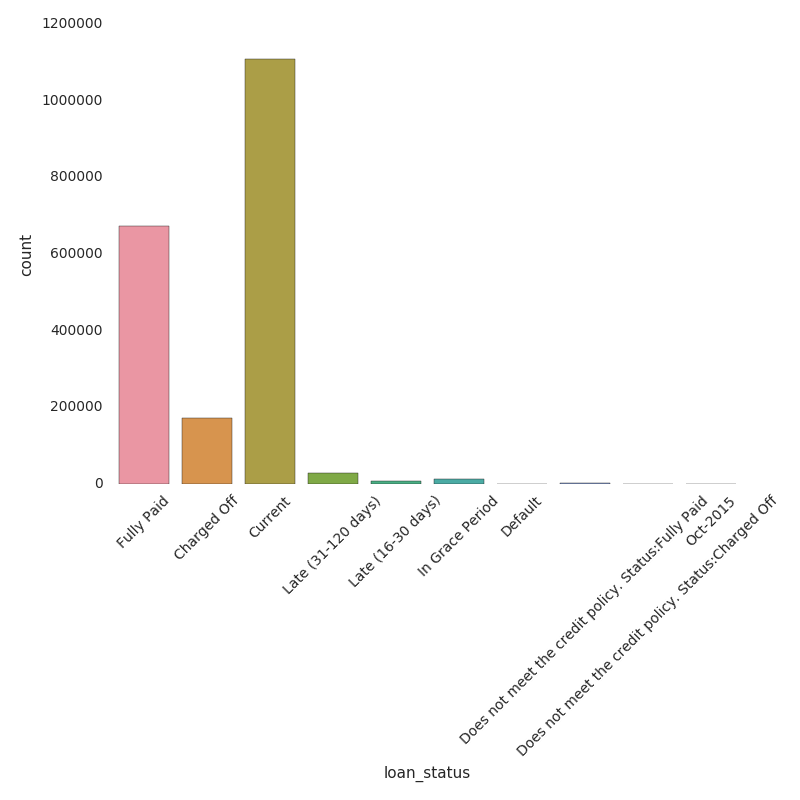

In [12]:
tmp = df_test.select("loan_status", "total_acc", "loan_amnt").toPandas()

fig, ax =plt.subplots(1,1,figsize=(8,8))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="loan_status", data=tmp,ax=ax)
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.tight_layout()
display(fig)

There are 11 different loan status. It will be grouped as "Fully Paid" and "Default" later, so a classification model for 2-class can be built. "null" and "Oct-2015" will be dropped.  
Be aware that it is imbalanced data.

Next, examine the overall loan situation over time, so we have a big picture about the business of Lending Club. Here I look at the total number of loans, total loan amount, median loan amount, and median interest rate.

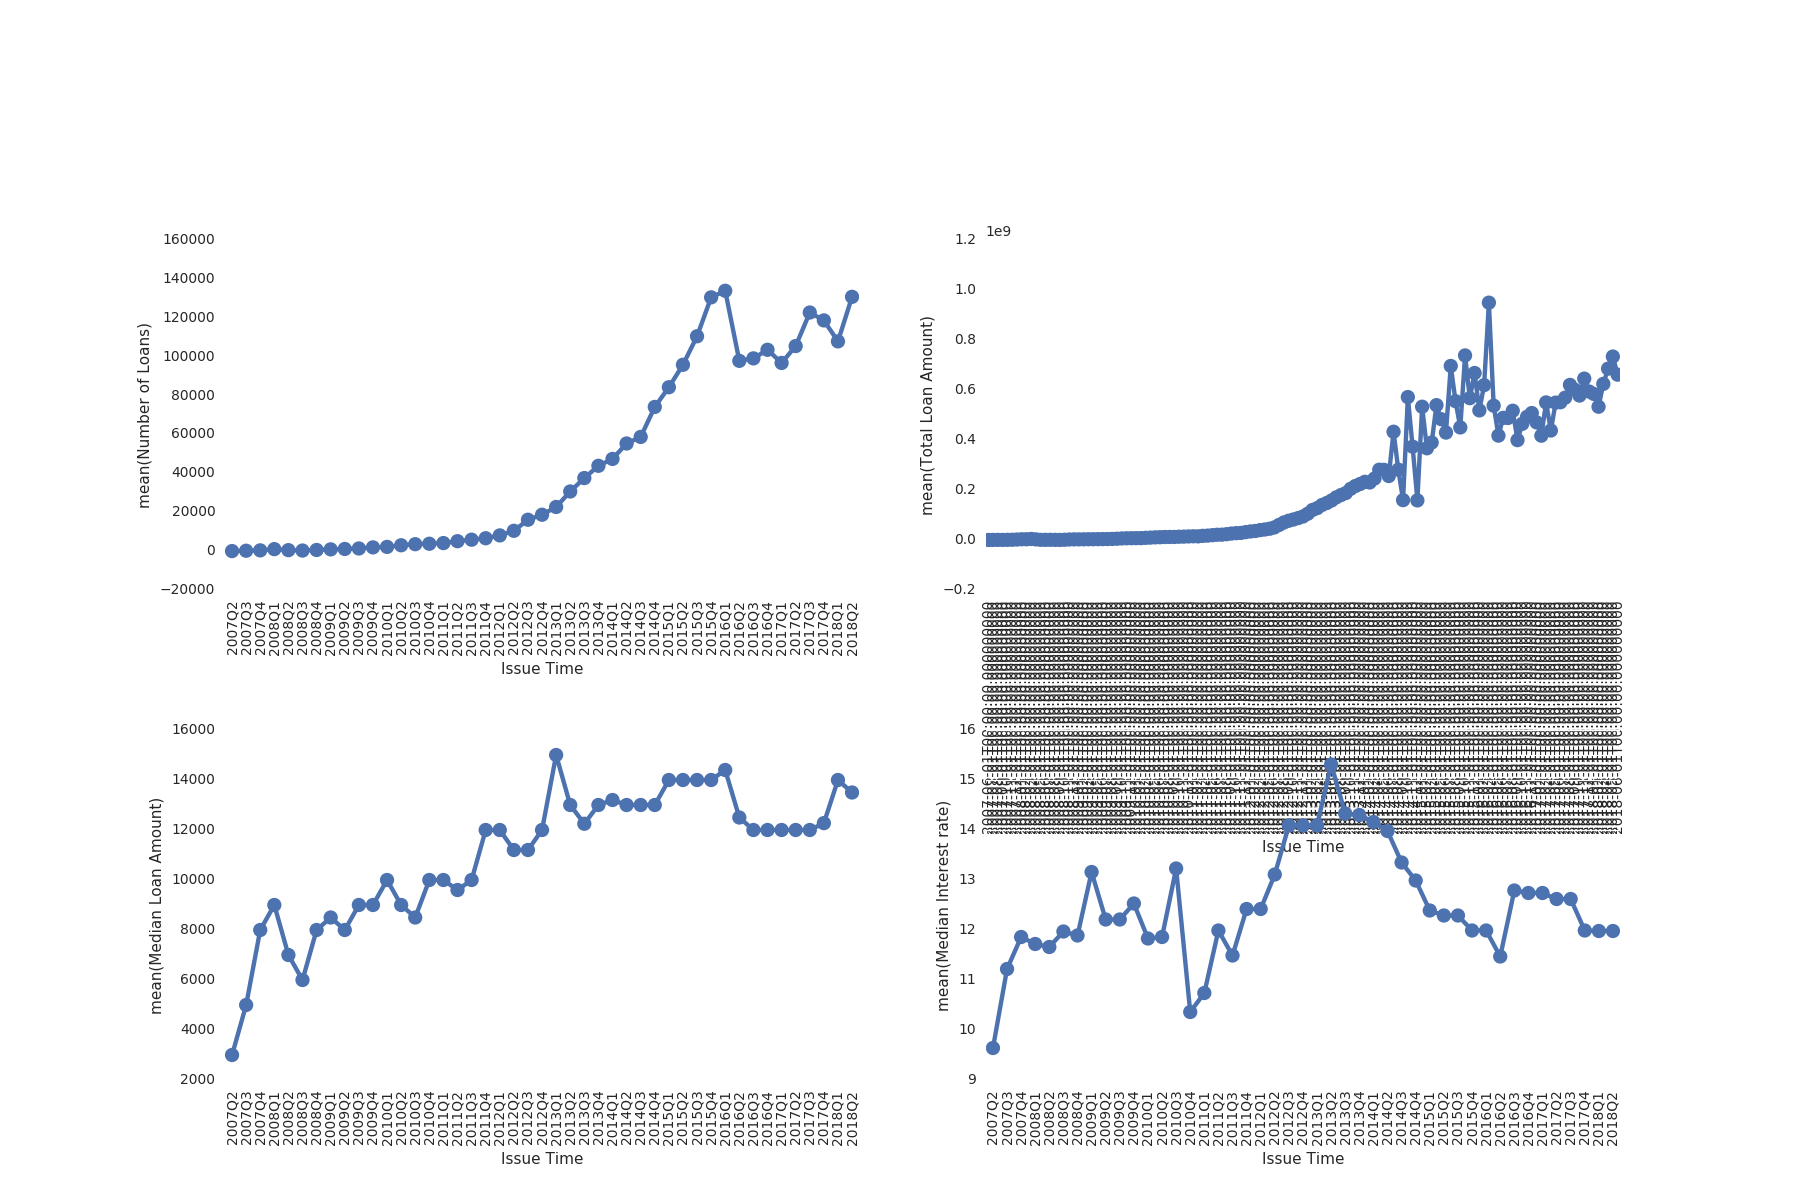

In [14]:
df_test = df_test.withColumn("issue_d_dateType", to_timestamp("issue_d", "MMM-yyyy"))
df_test = df_test.withColumn("issue_year", concat(year("issue_d_dateType"), lit("Q"), quarter("issue_d_dateType")))

df_test.registerTempTable("loanDFTable")

fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Number of loan over year
loansOverTime = df_test.sort("issue_year").groupBy("issue_year").count().toPandas()
loansOverTime.columns = ["Issue Time", "Number of Loans"]
s0=sns.pointplot(x=loansOverTime["Issue Time"], y=loansOverTime["Number of Loans"], ax=ax[0][0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=90)

# loan Amount over year
totalloansOverTime = df_test.sort("issue_d_dateType").groupBy("issue_d_dateType").sum('loan_amnt').toPandas()
totalloansOverTime.columns = ["Issue Time", "Total Loan Amount"]
s1 = sns.pointplot(x=totalloansOverTime['Issue Time'], y=totalloansOverTime["Total Loan Amount"], capsize=.2, ax=ax[0][1])
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)

# Median Loan Amount, grouped by issue year
medianloanAmtOverTime = sqlContext.sql("select issue_year, percentile_approx(loan_amnt, 0.5) as loan_amnt_med_val from loanDFTable group by issue_year order by issue_year").toPandas()
medianloanAmtOverTime.columns = ["Issue Time", "Median Loan Amount"]
s2 = sns.pointplot(x=medianloanAmtOverTime['Issue Time'], y=medianloanAmtOverTime["Median Loan Amount"], capsize=.2, ax=ax[1][0])
s2.set_xticklabels(s2.get_xticklabels(),rotation=90)

# Median Interest rate, grouped by issue year 
medianIntrateOverTime = sqlContext.sql("select issue_year, percentile_approx(int_rate, 0.5) as int_rate_med_val from loanDFTable group by issue_year order by issue_year").toPandas()
medianIntrateOverTime.columns = ["Issue Time", "Median Interest rate"]
s3 = sns.pointplot(x=medianIntrateOverTime['Issue Time'], y=medianIntrateOverTime["Median Interest rate"], capsize=.2, ax=ax[1][1])
s3.set_xticklabels(s3.get_xticklabels(),rotation=90)

display(fig)

Also, I examine the target variable, "loan_status", over time.

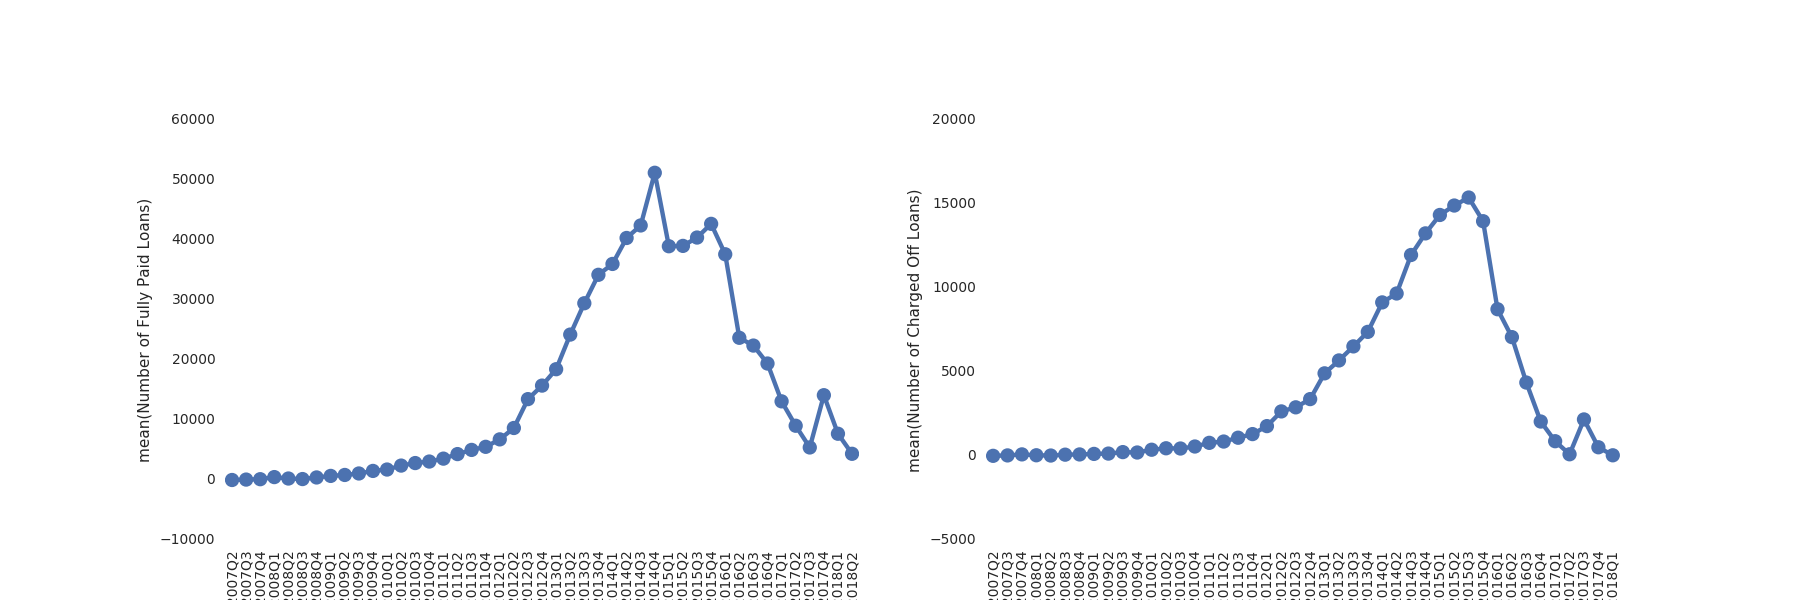

In [16]:
fig, ax =plt.subplots(1,2, figsize=(18,6))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

fullpaidOverTime = df_test[df_test['loan_status']=='Fully Paid'].sort("issue_year").groupBy("issue_year").count().toPandas()
fullpaidOverTime.columns = ["Issue Time", "Number of Fully Paid Loans"]
s0=sns.pointplot(x=fullpaidOverTime["Issue Time"], y=fullpaidOverTime["Number of Fully Paid Loans"], ax=ax[0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=90)

chargedOverTime = df_test[df_test['loan_status']=='Charged Off'].sort("issue_year").groupBy("issue_year").count().toPandas()
chargedOverTime.columns = ["Issue Time", "Number of Charged Off Loans"]
s1=sns.pointplot(x=chargedOverTime["Issue Time"], y=chargedOverTime["Number of Charged Off Loans"], ax=ax[1])
s1.set_xticklabels(s0.get_xticklabels(),rotation=90)

display(fig)

At this point, we know the business of Leading Club is going well, since more and more loans and clients they have. However, there is not much useful information about the defualt prediction.  
There is a gap between the peak of 'fully paid' and 'charge off', because if the client is not able to pay on time, there are 'grace period', 'late' status before the loan is considered 'charged off'. The term of the loan is either 3 years or 5 years, so the loans corresponding to the peaks were approved in 2011, which is consistent with the time when Lending Club had rapid growth. It is interesting to know if they change their policy at that time point. 

## 2. Data Cleaning and Feature Selection  
#### 2.1 Remove Feature with too much Missing Data  
Remove the features with over 50% of missing data

In [18]:
def findMissingValue(df):
    missingValueColumns = []
    N_rows = df.count()
    mis_val_table = sqlContext.createDataFrame([[0,0,0]], ["Num_Missing", "Ratio_Missing", 'type'])
    for column in df.columns:
        nullRows = df.where(col(column).isNull()).count()
        mis_val_percent = nullRows/N_rows
        mis_val_type = df.select(column).dtypes[0][1]
        if mis_val_percent > 0.5 : 
            missingValueColumns.append(column)
    return missingValueColumns

In [19]:
missing_Cols = findMissingValue(df_test)
missing_Cols

Out[ 16 ]: 
['member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'il_util',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [20]:
# Drop columns with over 50% missing data
df_test_model = df_test.drop(*missing_Cols)

In [21]:
df_test_model.where(col('inq_fi').isNull()).count()/df_test_model.count()

Out[ 44 ]: 0.43207984811260675

In [22]:
# The missing value in 'inq_fi' is also high (about 43%), this column is dropped.
df_test_model = df_test_model.drop('inq_fi')

#### 2.2 Feature Removal for Preventing Data Leakage  
Remove the features which should not be available when making the loan decision to prevent data leakage. In addition, in the use case, these features should not be in the predictive model. Also remove other non-informative features.

In [24]:

# Remove the features that were unavailable before lending a loan. The goal is to build a model for making lending decision, so only keep those features available when making the decision. 
df_test_model = df_test_model.drop(*['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim'])

#### 2.3 Remove Uninformative Features

In [26]:
# Drop ID (Unique id's, Don't help much in data analysis/modelling)
df_test_model = df_test_model.drop("id", "member_id")
# Keep address state feature instead of zip_code.
# The following features have only one category: application_type, pymnt_plan, initial_list_status, and policy_code
# the information in 'grade' is also in 'sub_grade', so keep 'sub_grade' and drop 'grade'
df_test_model = df_test_model.drop("emp_title", "url", "title", "zip_code", "earliest_cr_line", "last_pymnt_d", 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'grade', "next_pymnt_d", "last_credit_pull_d", "policy_code",  'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m',
 'open_rv_24m', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'inq_last_12m', 'total_acc', 'total_cu_tl')

#### 2.4 Feature Distribution and Outliers  
In this section, the following process is applied to the data:  
* Formatting: convert numeric features to 'float' data type  
* Visualize the distribution of the features group by 'loan_status'
* Provide preliminary examination on whether the features are different in distribution between 'Fully Paid' and 'Charged Off' groups.
* Remove outliers

In [28]:
# Convert the numeric features to float data type
df_test_model = df_test_model.withColumn("loan_amnt",df_test_model["loan_amnt"].cast('float'))
df_test_model = df_test_model.withColumn("int_rate",df_test_model["int_rate"].cast('float'))
df_test_model = df_test_model.withColumn("installment",df_test_model["installment"].cast('float'))
df_test_model = df_test_model.withColumn("annual_inc",df_test_model["annual_inc"].cast('float'))
df_test_model = df_test_model.withColumn("dti",df_test_model["dti"].cast('float'))
df_test_model = df_test_model.withColumn("open_acc",df_test_model["open_acc"].cast('float'))
df_test_model = df_test_model.withColumn("total_acc",df_test["total_acc"].cast('float'))
df_test_model = df_test_model.withColumn("pub_rec",df_test_model["pub_rec"].cast('float'))
df_test_model = df_test_model.withColumn("revol_bal",df_test_model["revol_bal"].cast('float'))
df_test_model = df_test_model.withColumn("revol_util",df_test_model["revol_util"].cast('float'))
df_test_model = df_test_model.withColumn('all_util',df_test_model['all_util'].cast('float'))
df_test_model = df_test_model.withColumn("inq_fi",df_test_model["inq_fi"].cast('float'))
df_test_model = df_test_model.withColumn('mort_acc',df_test_model['mort_acc'].cast('float'))
df_test_model = df_test_model.withColumn('pub_rec_bankruptcies',df_test_model['pub_rec_bankruptcies'].cast('float'))
df_test_model = df_test_model.withColumn('fico_range_high',df_test_model['fico_range_high'].cast('float'))
df_test_model = df_test_model.withColumn('fico_range_low',df_test_model['fico_range_low'].cast('float'))
df_test_model = df_test_model.withColumn('annual_inc',df_test_model['annual_inc'].cast('float'))

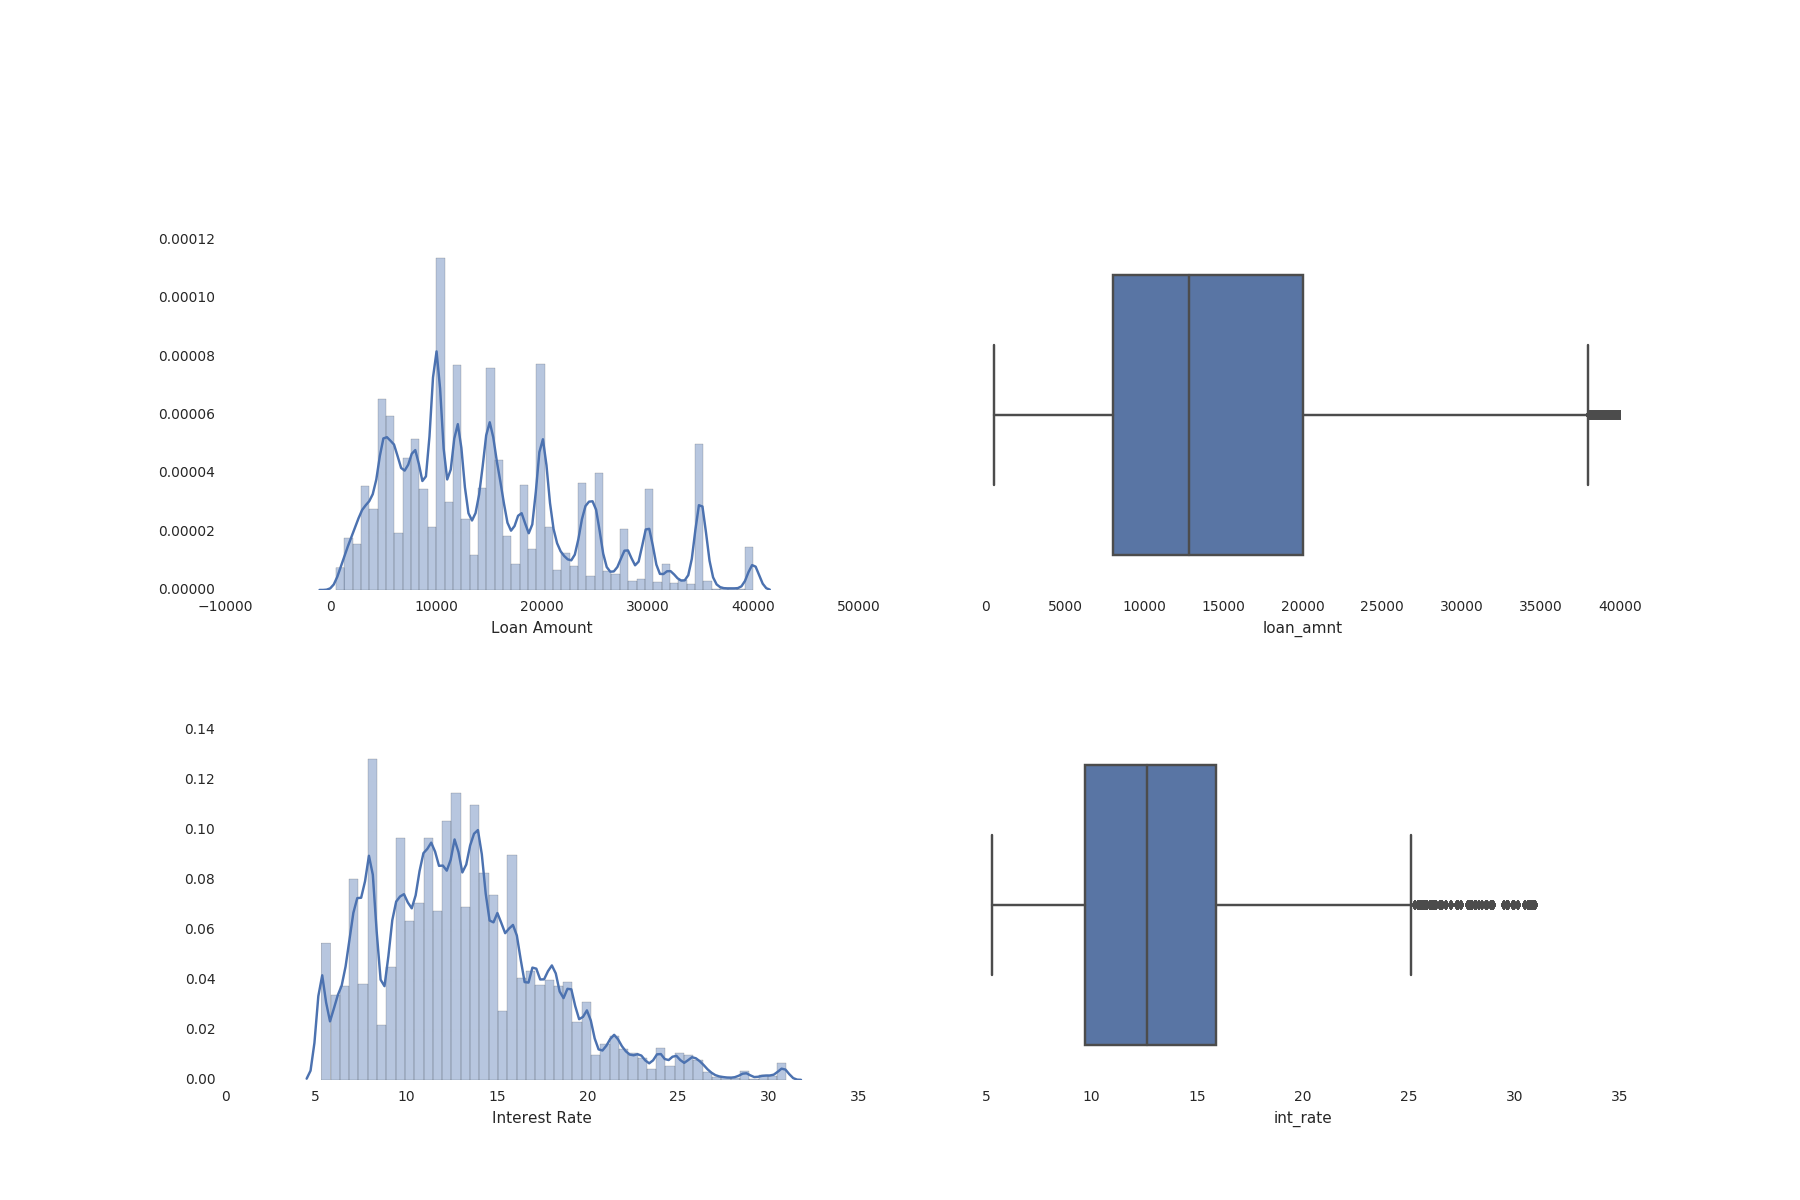

In [29]:
tmp = df_test_model.select("loan_amnt", "int_rate").toPandas()

fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Loan amount distribution plots
sns.distplot(tmp.loan_amnt.dropna(), axlabel="Loan Amount", label="Loan Amount Frequency distribution", ax=ax[0][0])
sns.boxplot(x=tmp.loan_amnt, ax=ax[0][1])

# Interest rates distribution plots
sns.distplot(tmp.int_rate.dropna(), axlabel="Interest Rate", label="Interest Frequency distribution", ax=ax[1][0])
sns.boxplot(x=tmp.int_rate, ax=ax[1][1])

display(fig)

Examine the descriptive statistics of every feature. It provides preliminary information on outliers and indicates the feautres needed to be further cleaned-up.

In [31]:
for col in df_test_model.columns:
  df_test_model.select(col).describe().show()

+-------+------------------+
summary| loan_amnt|
+-------+------------------+
 count| 2004062|
 mean|14920.727839258467|
 stddev| 9056.245502630174|
 min| 500.0|
 max| 40000.0|
+-------+------------------+

+-------+----------+
summary| term|
+-------+----------+
 count| 2004062|
 mean| null|
 stddev| null|
 min| 36 months|
 max| 60 months|
+-------+----------+

+-------+------------------+
summary| int_rate|
+-------+------------------+
 count| 2004062|
 mean|13.112800846266351|
 stddev| 4.778923964189021|
 min| 5.31|
 max| 30.99|
+-------+------------------+

+-------+-----------------+
summary| installment|
+-------+-----------------+
 count| 2004062|
 mean| 443.088790613363|
 stddev|264.5074295658514|
 min| 4.93|
 max| 1719.83|
+-------+-----------------+

+-------+---------+
summary|sub_grade|
+-------+---------+
 count| 2004062|
 mean| null|
 stddev| null|
 min| A1|
 max| G5|
+-------+---------+

+-------+----------+
summary|emp_length|
+-------+----------+
 count| 1879246|
 mean| null|
 stddev| null|
 min| reactors"|
 max| < 1 year|
+-------+----------+

+-------+--------------+
summary|home_ownership|
+-------+--------------+
 count| 2004062|
 mean| null|
 stddev| null|
 min| 2 years|
 max| RENT|
+-------+--------------+

+-------+------------------+
summary| annual_inc|
+-------+------------------+
 count| 2004057|
 mean| 77546.60258563703|
 stddev|114855.03489262151|
 min| 0.0|
 max| 1.1E8|
+-------+------------------+

+-------+-------------------+
summary|verification_status|
+-------+-------------------+
 count| 2004062|
 mean| 38000.0|
 stddev| NaN|
 min| 38000.0|
 max| Verified|
+-------+-------------------+

+-------+---------------+
summary| issue_d|
+-------+---------------+
 count| 2004062|
 mean| null|
 stddev| null|
 min| Apr-2008|
 max|Source Verified|
+-------+---------------+

+-------+-----------+
summary|loan_status|
+-------+-----------+
 count| 2004062|
 mean| null|
 stddev| null|
 min|Charged Off|
 max| Oct-2015|
+-------+-----------+

+-------+--------------------+
summary| purpose|
+-------+--------------------+
 count| 2004061|
 mean| 384.0|
 stddev| 543.0580079512685|
 min| After gradu...|
 max| wedding|
+-------+--------------------+

+-------+--------------------+
summary| addr_state|
+-------+--------------------+
 count| 2004061|
 mean| 0.0|
 stddev| NaN|
 min| American women u...|
 max| wedding|
+-------+--------------------+

+-------+------------------+
summary| dti|
+-------+------------------+
 count| 2002639|
 mean|18.691042664208418|
 stddev|13.180725327559578|
 min| -1.0|
 max| 999.0|
+-------+------------------+

+-------+------------------+
summary| open_acc|
+-------+------------------+
 count| 2003901|
 mean|11.632221571824482|
 stddev| 6.400741503337736|
 min| 0.0|
 max| 800.0|
+-------+------------------+

+-------+-------------------+
summary| pub_rec|
+-------+-------------------+
 count| 2003927|
 mean|0.21685138231046266|
 stddev| 2.614745823864284|
 min| 0.0|
 max| 804.0|
+-------+-------------------+

+-------+------------------+
summary| revol_bal|
+-------+------------------+
 count| 2003970|
 mean|16649.059667854308|
 stddev| 22921.86751266701|
 min| 0.0|
 max| 2904836.0|
+-------+------------------+

+-------+-----------------+
summary| revol_util|
+-------+-----------------+
 count| 2002485|
 mean|51.70272373963404|
 stddev|196.6059388253861|
 min| 0.0|
 max| 152002.0|
+-------+-----------------+

+-------+------------------+
summary| total_acc|
+-------+------------------+
 count| 2003989|
 mean| 24.68817156681189|
 stddev|110.39772459900435|
 min| 0.0|
 max| 89832.0|
+-------+------------------+

+-------+--------------------+
summary| initial_list_status|
+-------+--------------------+
 count| 2004045|
 mean| 2470.255207373272|
 stddev| 6979.857129762963|
 min| and I pay her tu...|
 max| w|
+-------+--------------------+

+-------+-----------------+
summary| application_type|
+-------+-----------------+
 count| 2004007|
 mean|885.0797536667302|
 stddev|2697.30315

The following figures compare the feature distribution between 'Fully Paid' and 'Charged Off' groups.

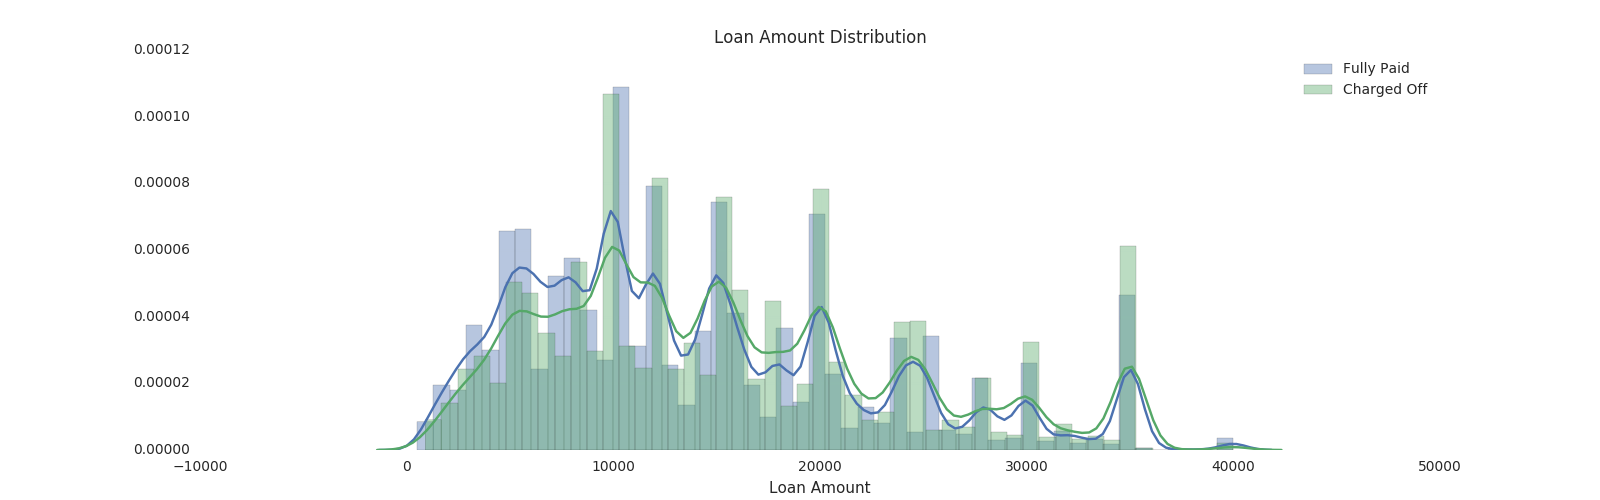

In [33]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('loan_amnt').toPandas()
df_chargedoff_la = df_chargedoff.select('loan_amnt').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la,label='Fully Paid')
sns.distplot(df_chargedoff_la, ax=ax, label='Charged Off')
plt.title("Loan Amount Distribution")
plt.xlabel('Loan Amount')
plt.legend()
display(fig)

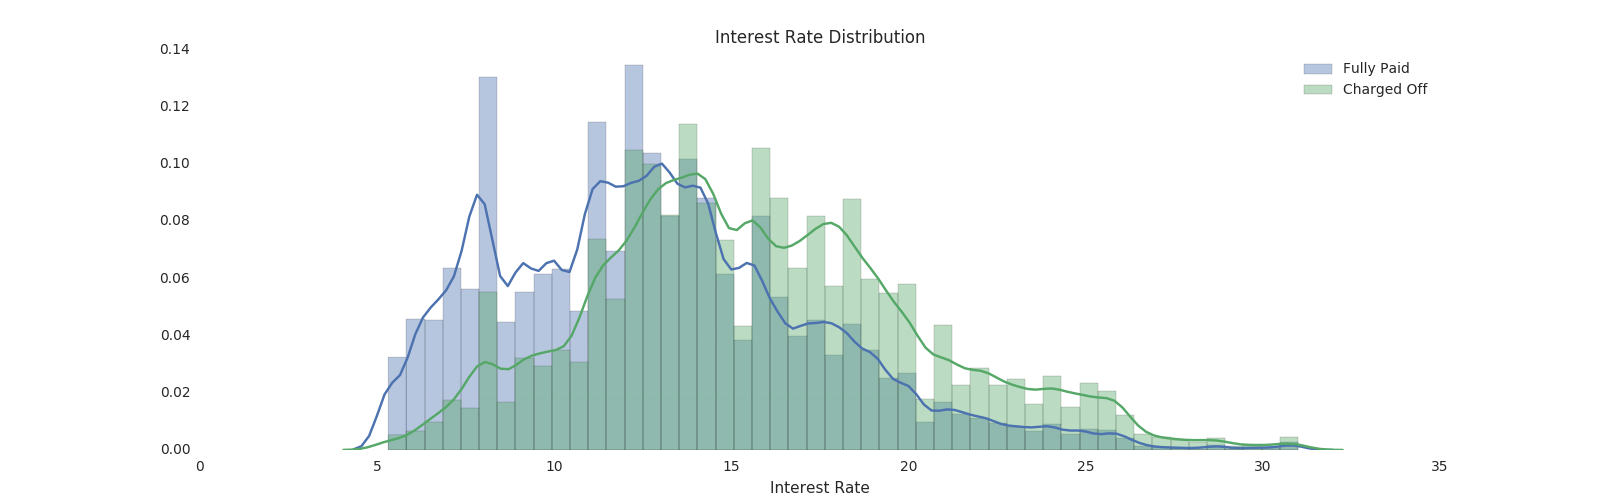

In [34]:
df_paid_la = df_paid.select('int_rate').toPandas()
df_chargedoff_la = df_chargedoff.select('int_rate').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la,label='Fully Paid')
sns.distplot(df_chargedoff_la, ax=ax, label='Charged Off')
plt.title("Interest Rate Distribution")
plt.xlabel('Interest Rate')
plt.legend()
display(fig)


In [35]:
df_test_model.select('annual_inc').describe().show()

+-------+------------------+
summary| annual_inc|
+-------+------------------+
 count| 2004057|
 mean| 77546.60258563703|
 stddev|114855.03489262151|
 min| 0.0|
 max| 1.1E8|
+-------+------------------+

The annual income is self-reported, and the maximum is not reasonable.

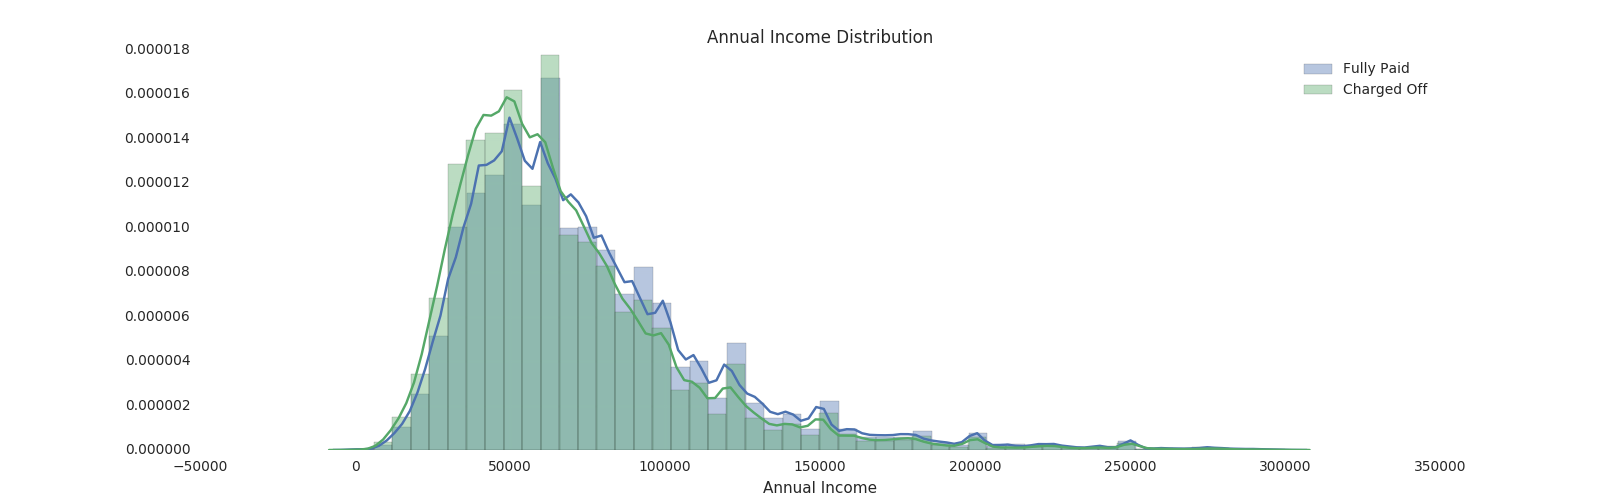

In [37]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid'][df_test['annual_inc']<300000]
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off'][df_test['annual_inc']<300000]
df_paid_la = df_paid.select('annual_inc').toPandas()
df_chargedoff_la = df_chargedoff.select('annual_inc').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la,label='Fully Paid')
sns.distplot(df_chargedoff_la, ax=ax, label='Charged Off')
plt.title("Annual Income Distribution")
plt.xlabel('Annual Income')
plt.legend()
display(fig)

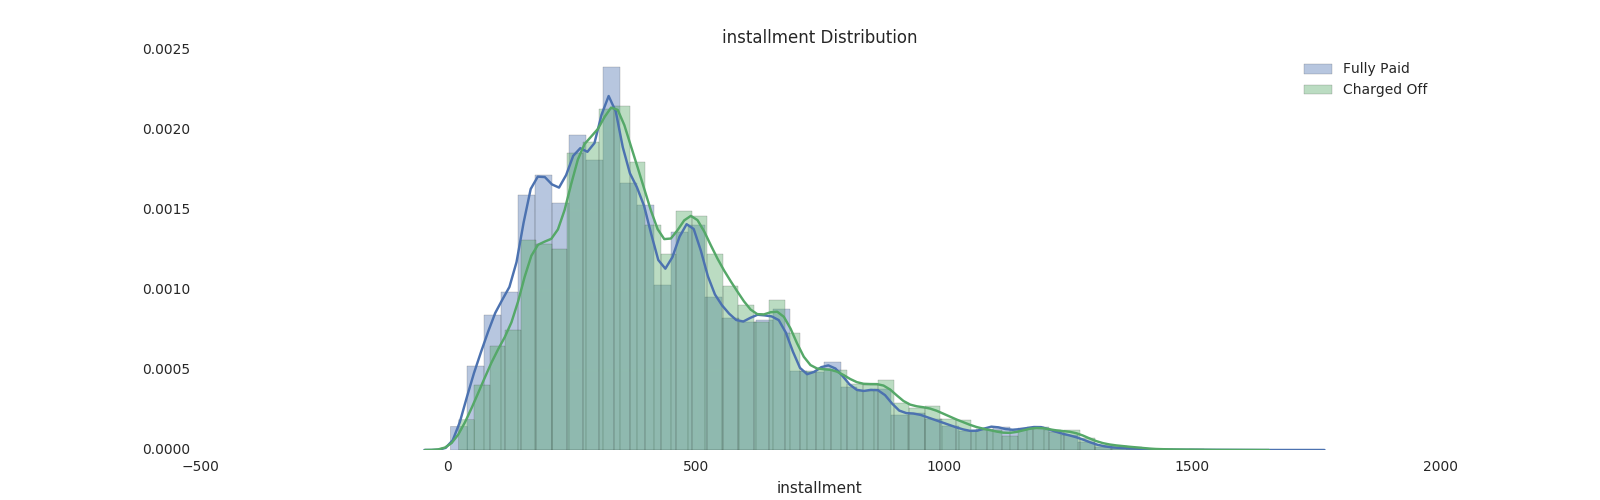

In [38]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('installment').toPandas()
df_chargedoff_la = df_chargedoff.select('installment').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la,label='Fully Paid')
sns.distplot(df_chargedoff_la, ax=ax, label='Charged Off')
plt.title("installment Distribution")
plt.xlabel('installment')
plt.legend()
display(fig)

In [39]:
df_test_model.select('dti').describe().show()

+-------+------------------+
summary| dti|
+-------+------------------+
 count| 2002639|
 mean|18.691042664208418|
 stddev|13.180725327559578|
 min| -1.0|
 max| 999.0|
+-------+------------------+

"dti": debt to income ratio, "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."  
The maximum, 999, and the minimum, -1, are both not reasonable.

In [41]:
df_test_model[df_test_model.dti<0].count()

Out[ 81 ]: 2

In [42]:
df_test_model = df_test_model[df_test_model.dti<200]
df_test_model = df_test_model[df_test_model.dti>=0]

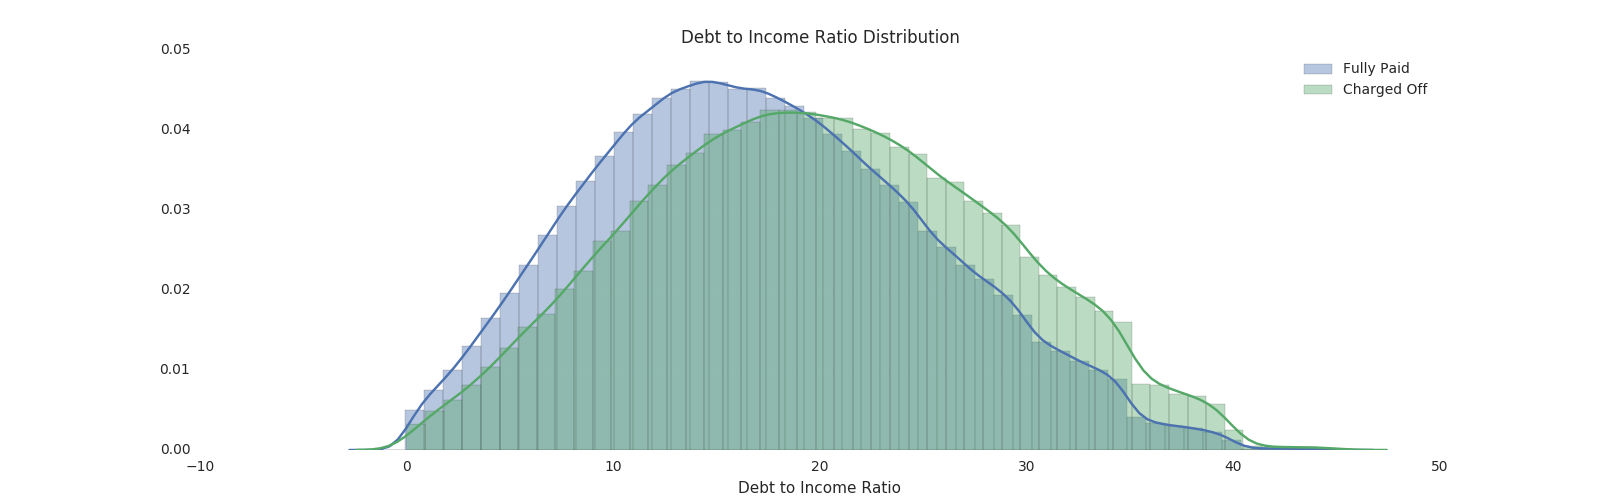

In [43]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid'][df_test['dti']<45]
df_chargedoff = df_test[df_test_model['loan_status']=='Charged Off'][df_test['dti']<45]
df_paid_la = df_paid.select('dti').toPandas()
df_chargedoff_la = df_chargedoff.select('dti').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la,label='Fully Paid')
sns.distplot(df_chargedoff_la, ax=ax, label='Charged Off')
plt.title("Debt to Income Ratio Distribution")
plt.xlabel('Debt to Income Ratio')
plt.legend()
display(fig)

Feature engineer on the fico score. After examined, 'fico_range_high' and 'fico_range_low' do not provide different information, so the do not need to keep both. I replace these two features by the average of them.

In [45]:
df_test_model = df_test_model.withColumn('fico_score',((df_test['fico_range_high']+df_test['fico_range_low'])/2).cast('float'))

In [46]:
df_test_model.select('fico_score').describe().show()

+-------+-----------------+
summary| fico_score|
+-------+-----------------+
 count| 2003846|
 mean|699.6628519382227|
 stddev|32.74107787471552|
 min| 0.245|
 max| 847.5|
+-------+-----------------+

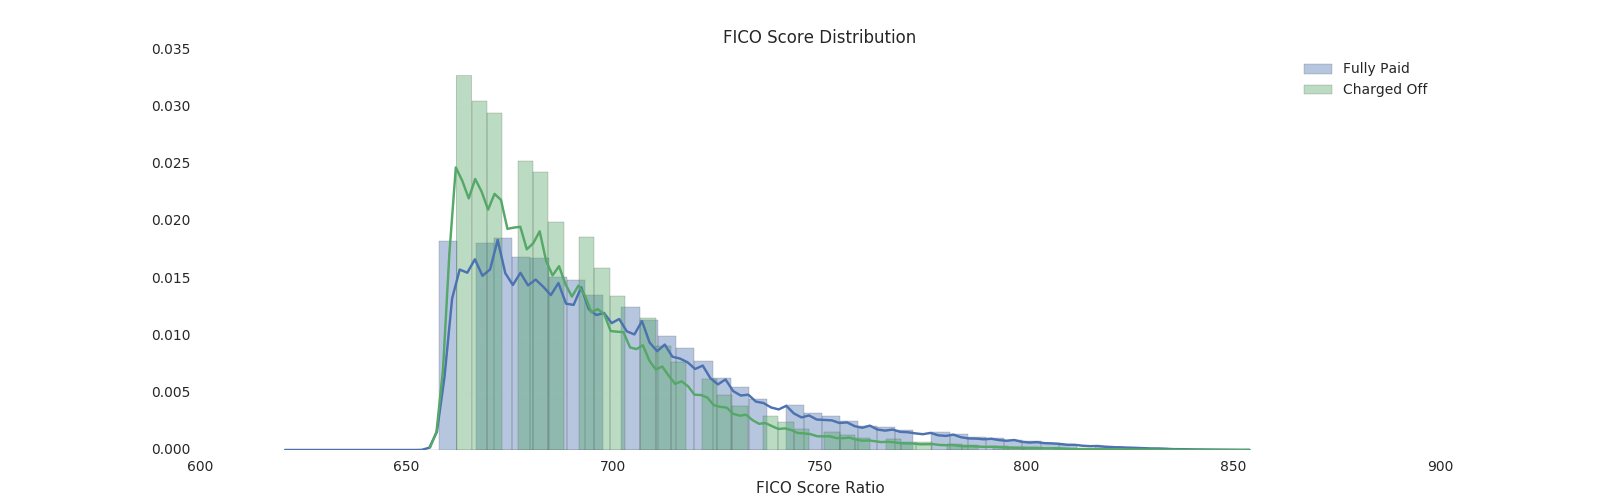

In [47]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid'][df_test['fico_score']>600]
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off'][df_test['fico_score']>600]
df_paid_la = df_paid.select('fico_score').toPandas()
df_chargedoff_la = df_chargedoff.select('fico_score').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("FICO Score Distribution")
plt.xlabel('FICO Score Ratio')
plt.legend()
display(fig)

While the maximum is extremely high, there is no much clients have fico lower than 650. Maybe their loan applications were rejected by Lending Club at the first place.  
After further examined, other non-informative features are removed.

There's one extreme value that the number of open account is 800. Remove this data point and also other extreme values.  
The removal criteria is decided by observing the distribution of the future, and the following only present the distribution after removal extreme values.

In [50]:
df_test_model = df_test_model[df_test_model.open_acc<100]

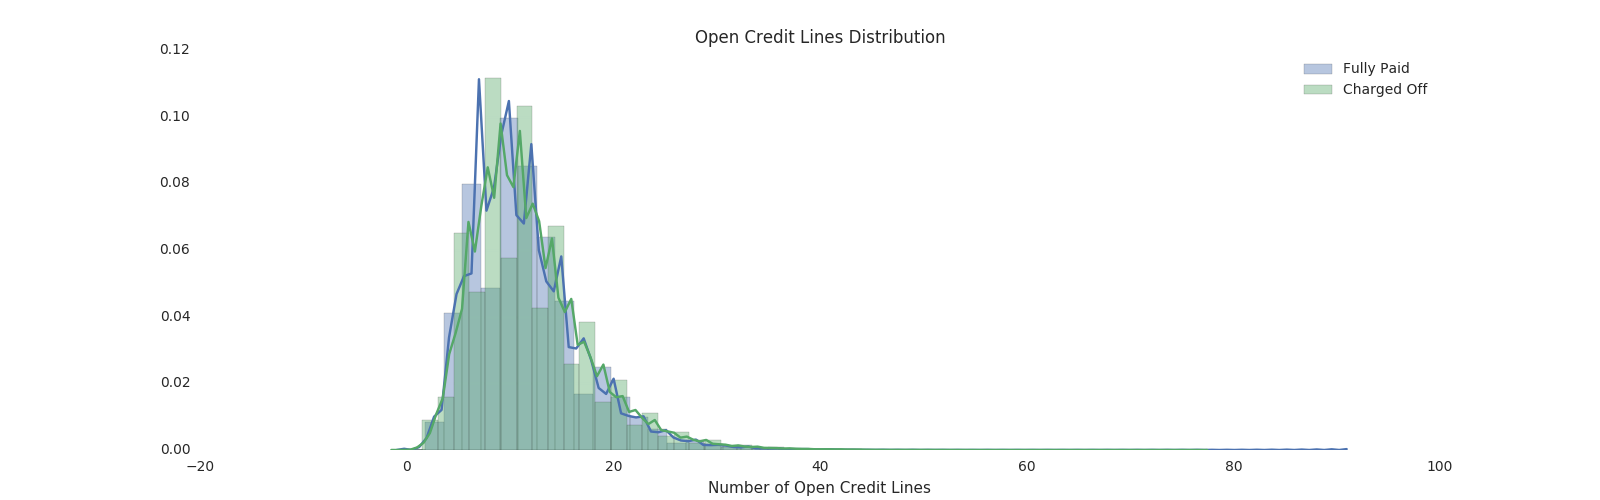

In [51]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('open_acc').toPandas()
df_chargedoff_la = df_chargedoff.select('open_acc').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Open Credit Lines Distribution")
plt.xlabel('Number of Open Credit Lines')
plt.legend()
display(fig)

In [52]:
# The maximum of Number of derogatory public records is 804. It's considered as an outlier. After exam the mean and std. dev., the extreme value will be removed.
df_test_model[df_test_model.pub_rec>10].count()

Out[ 21 ]: 218

In [53]:
df_test_model = df_test_model[df_test_model.pub_rec<10]
df_test_model.count()

Out[ 23 ]: 1998640

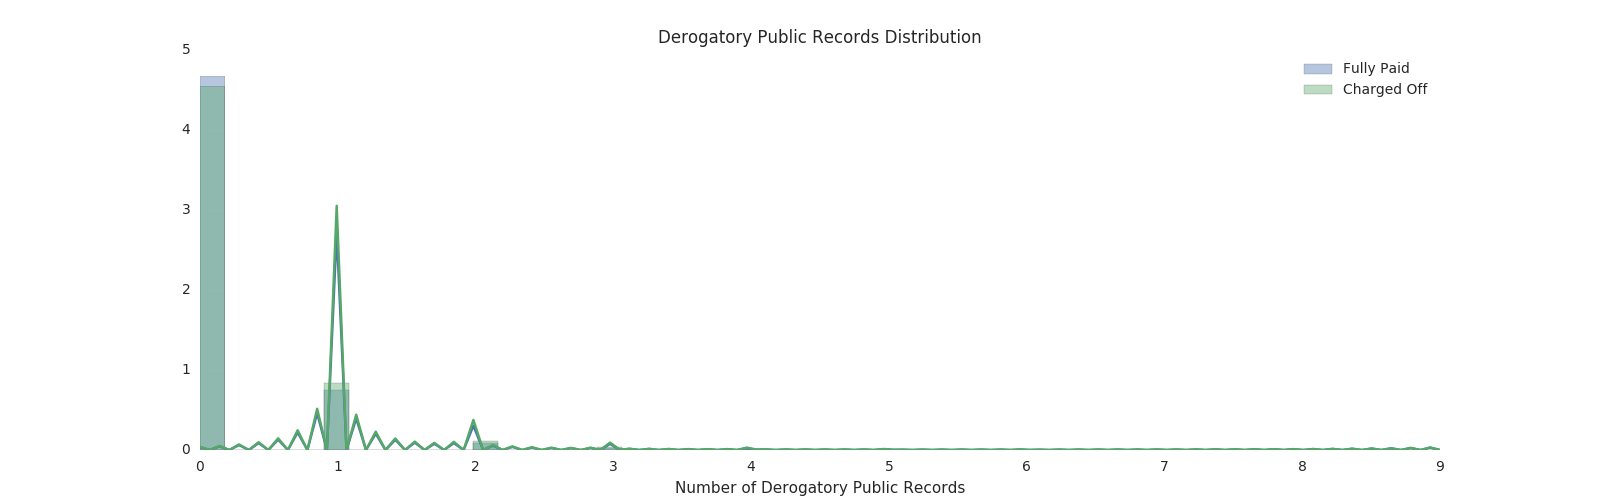

In [54]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('pub_rec').toPandas()
df_chargedoff_la = df_chargedoff.select('pub_rec').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Derogatory Public Records Distribution")
plt.xlabel('Number of Derogatory Public Records')
plt.legend()
display(fig)

In [55]:
# The maximum of revolving balance is about $3M, but the mean is about $17k, so the extreme value is removed.
df_test_model[df_test_model.revol_bal>300000].count()

Out[ 25 ]: 1457

In [56]:
df_test_model = df_test_model[df_test_model.revol_bal<300000]

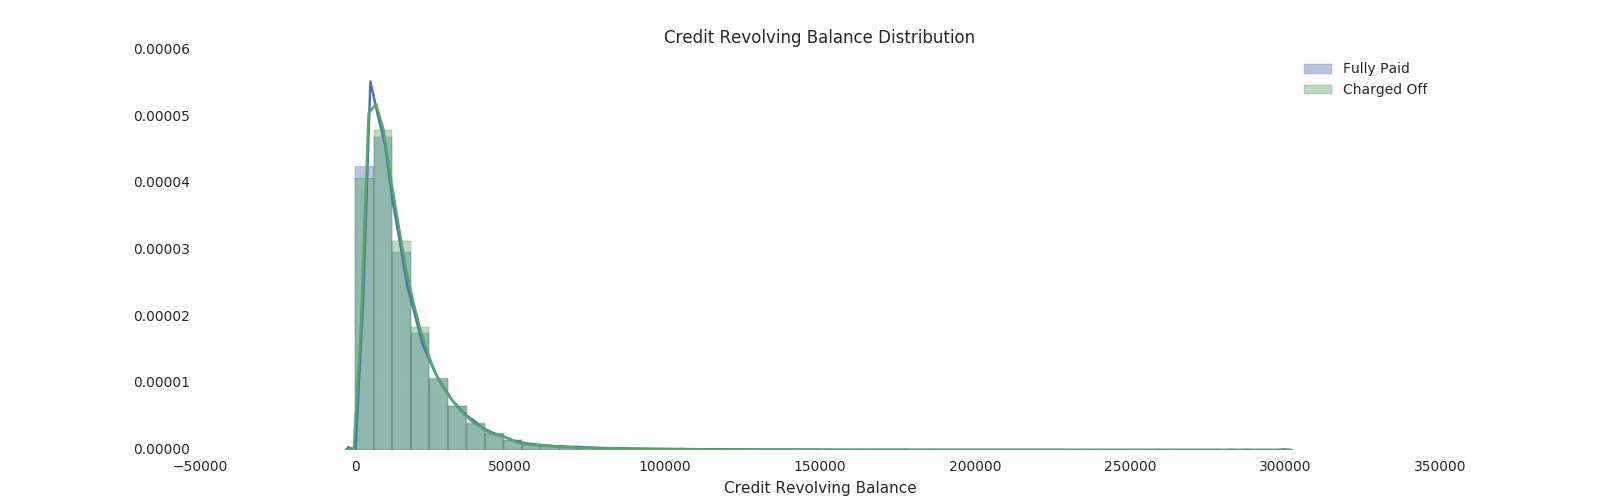

In [57]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('revol_bal').toPandas()
df_chargedoff_la = df_chargedoff.select('revol_bal').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Credit Revolving Balance Distribution")
plt.xlabel('Credit Revolving Balance')
plt.legend()
display(fig)

In [58]:
# The maximum of revoling utilization is 152k, which is far from reasonable. The extereme values are removed.
df_test_model[df_test_model.revol_util>150].count()

Out[ 27 ]: 25

In [59]:
df_test_model = df_test_model[df_test_model.revol_util<150]
df_test_model.count()

Out[ 34 ]: 1995689

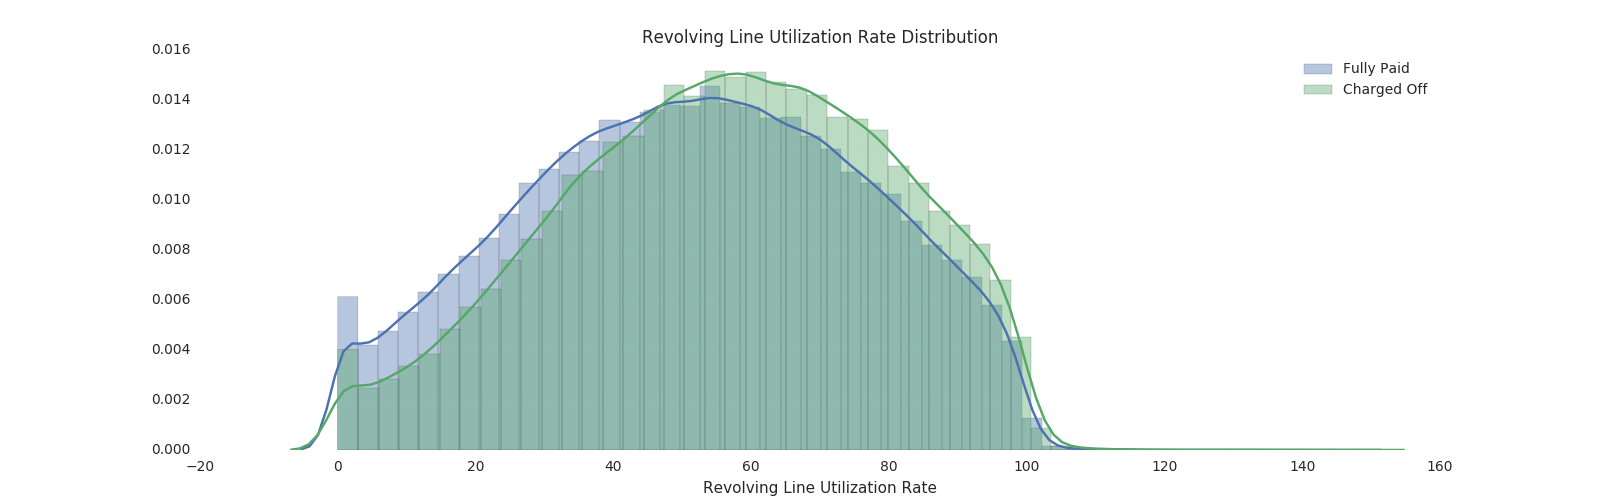

In [60]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('revol_util').toPandas()
df_chargedoff_la = df_chargedoff.select('revol_util').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Revolving Line Utilization Rate Distribution")
plt.xlabel('Revolving Line Utilization Rate')
plt.legend()
display(fig)

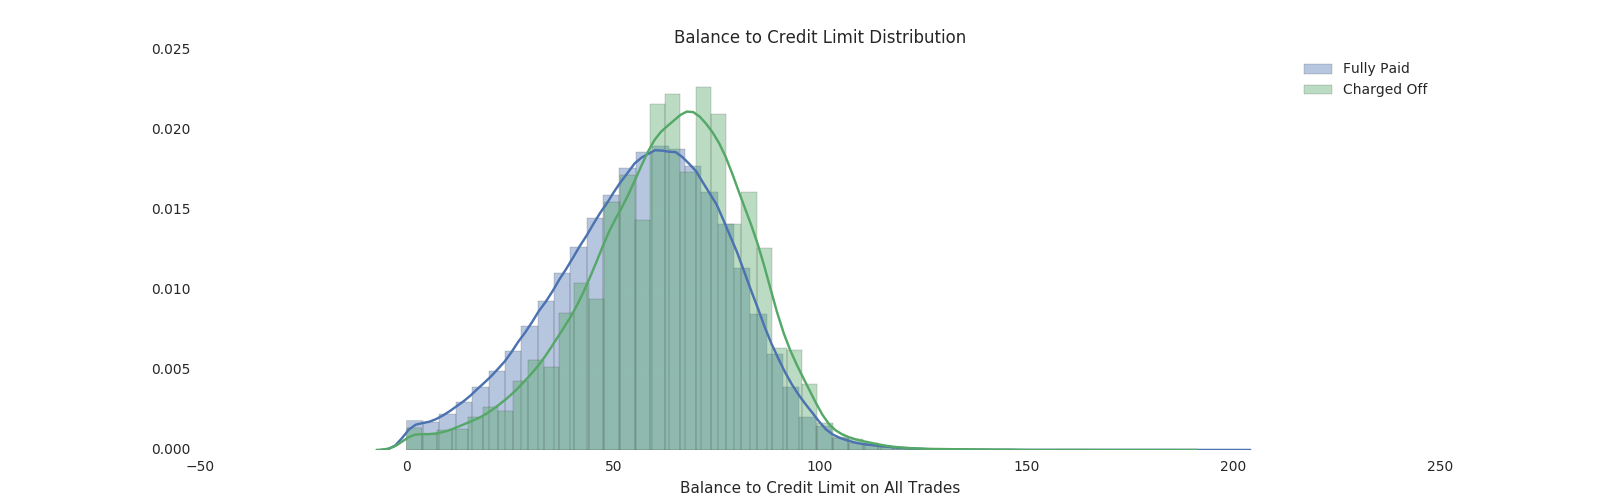

In [61]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('all_util').toPandas()
df_chargedoff_la = df_chargedoff.select('all_util').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Balance to Credit Limit Distribution")
plt.xlabel('Balance to Credit Limit on All Trades')
plt.legend()
display(fig)

In [62]:
# The maximum number of morgage account is 94. Remove those greater than 20.
df_test_model = df_test_model[df_test_model.mort_acc<=20]
df_test_model[df_test_model.mort_acc<=20].count()

Out[ 61 ]: 1946150

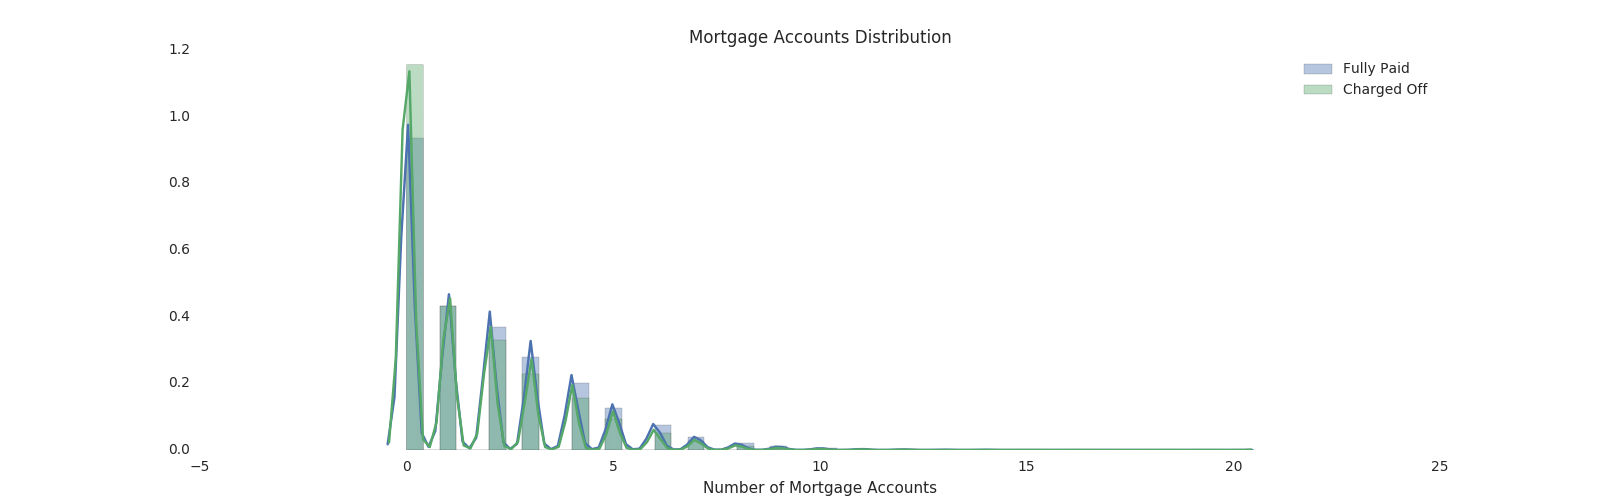

In [63]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('mort_acc').toPandas()
df_chargedoff_la = df_chargedoff.select('mort_acc').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Mortgage Accounts Distribution")
plt.xlabel('Number of Mortgage Accounts')
plt.legend()
display(fig)


In [64]:
df_test_model.select('pub_rec_bankruptcies').describe().show()

+-------+--------------------+
summary|pub_rec_bankruptcies|
+-------+--------------------+
 count| 1946150|
 mean| 0.13133468643218663|
 stddev| 0.37129790045330585|
 min| 0.0|
 max| 9.0|
+-------+--------------------+

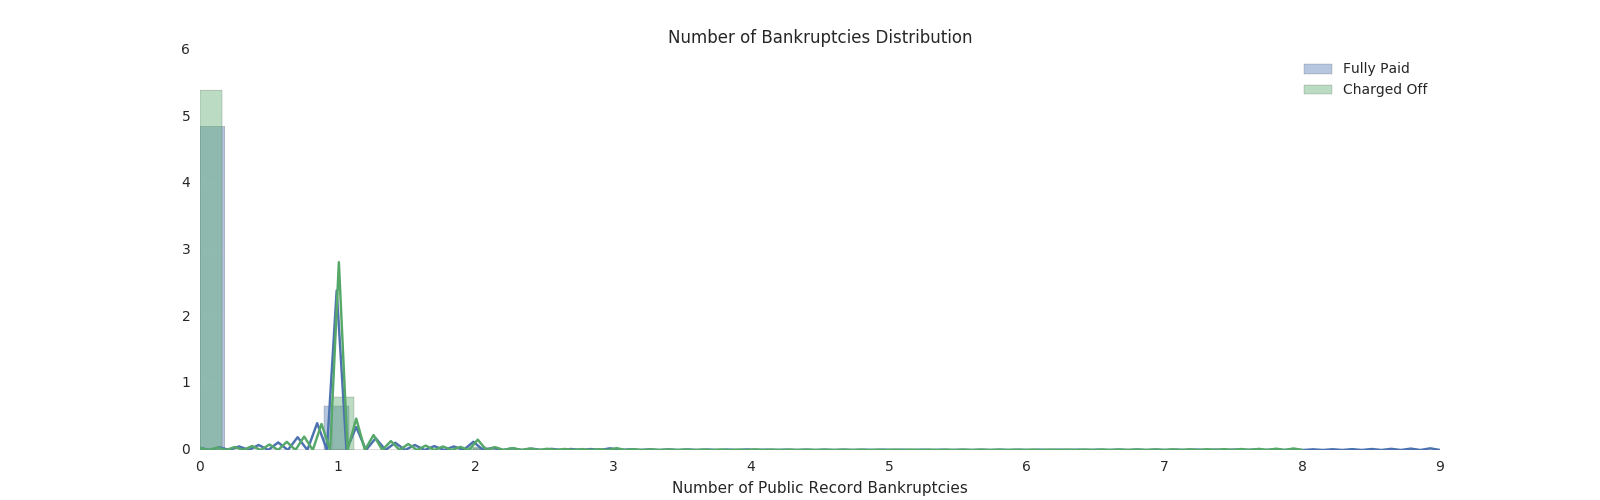

In [65]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('pub_rec_bankruptcies').toPandas()
df_chargedoff_la = df_chargedoff.select('pub_rec_bankruptcies').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Number of Bankruptcies Distribution")
plt.xlabel('Number of Public Record Bankruptcies')
plt.legend()
display(fig)

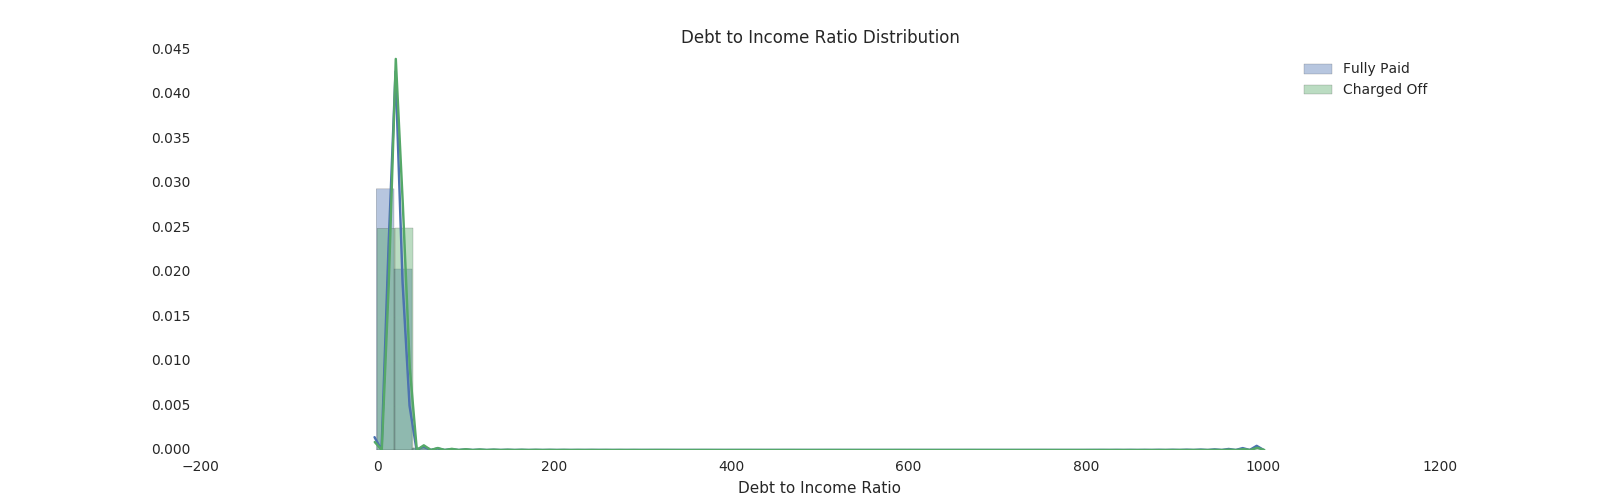

In [66]:
df_paid = df_test_model[df_test_model['loan_status']=='Fully Paid']
df_chargedoff = df_test_model[df_test_model['loan_status']=='Charged Off']
df_paid_la = df_paid.select('dti').toPandas()
df_chargedoff_la = df_chargedoff.select('dti').toPandas()
fig, ax =plt.subplots(1,1,figsize=(16,5))
ax = sns.distplot(df_paid_la.dropna(),label='Fully Paid')
sns.distplot(df_chargedoff_la.dropna(), ax=ax, label='Charged Off')
plt.title("Debt to Income Ratio Distribution")
plt.xlabel('Debt to Income Ratio')
plt.legend()
display(fig)

By Observation, the following features have different distribution between 'Fullay Paid' and 'Charged Off' groups: loan amount, interest rate, annual income, debt to income ratio, FICo score, revolving line utilization, and balance to credit limit. Of course the conclusion is not able to be drawm at this early stage, but it provide some preliminary information about the features, and we can pay more attention on them in modeling and analysis.
#### 2.5 Data Cleaning for categorical features

Remove the data whose address is not in the 50 states

In [69]:
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

In [70]:
df_test_model[df_test_model.addr_state.isin(state_list)].count()

Out[ 81 ]: 1998978

In [71]:
df_test_model[df_test_model.addr_state.isin(state_list)].count()/df_test_model.count()

Out[ 93 ]: 0.9974487186460096

Only 0.03% of data is not in the 50 states.

In [73]:
# drop 0.03% data
df_test_model = df_test_model[df_test_model.addr_state.isin(state_list)]

In [74]:
df_test_model.select('purpose').distinct().count()

Out[ 82 ]: 269

In [75]:
df_purpose = df_test_model.groupBy('purpose').count().toPandas()
df_purpose.columns = ['purpose', 'num']

In [76]:
df_purpose.sort('num',ascending=False)

Out[ 92 ]: 
 purpose num
133 debt_consolidation 1137372
140 credit_card 446623
253 home_improvement 134984
88 other 125438
230 major_purchase 45787
233 medical 24582
89 small_business 22665
228 car 21916
147 moving 13964
190 vacation 13888
198 house 12520
45 wedding 2351
193 renewable_energy 1305
52 educational 412
48 None 30
179 000 annually. We are easily able to pay are m... 1
181 and wish to explore how the borrower side of ... 1
180 a school being built in Kenya for deaf childr... 1
196 and are paid in full by him each month. A li... 1
178 movies 1
182 and I would like to keep the finance charges ... 1
176 eat greek meals"".There is a golf course and >... 1
175 Butler PA. It is currently rented out so repa... 1
174 just pending bank approval from the buyer) . ... 1
177 I am a good borrower because I have the abili... 1
184 but given the changes in the credit card indu... 1
183 and the young lady I talked to that works for... 1
195 in other words 1
173 since sometimes the investors are quicker tha... 1
186 but it has 160 1
.. ... ...
71 "" even though I've made my payments on time f... 1
72 my income exceeds my expenses and I'm very me... 1
73 in case a lawsuit was filed AFTER I moved 1
74 and by understanding this issue 1
75 it was going to be tougher then I thought. Lo... 1
76 it was too late to call and they are not open... 1
77 and another one coming up 1
78 proms 1
79 as my credit rating is very high & I am very... 1
80 they love me 1
81 affordable family adventures. Some of these i... 1
82 and to be debt free by three years. This pla... 1
83 but I could not 1
84 300 across 3 retirement accounts. I save 5% o... 1
85 20 foot Yamaha sport boat is quite a beauty 1
86 looking better than ever."" The unit include... 1
87 my monthly budget is $3 1
90 so I have to pay for my loss 1
91 Own my Car outright 1
92 which is their life and possibly career one d... 1
93 low Rate. Tired of Writing / E paying 1
94 or over my credit limit? No! They are raising... 1
95 putting together an apartment here 1
96 PA). " 1
97 fence and do landscaping work around our prop... 1
98 Macy's Visa is not new debt. That account wa... 1
99 at lower interest rates 1
100 again 1
101 my wife and I 1
268 I will never be able to spend time with our b... 1

[269 rows x 2 columns]

There are too many kinds of 'purpose', but most of them are noise. Only the top 14 purposes are meaningful, so keep them, and remove the rest.

In [78]:
purpose_list = ['debt_consolidation', 'credit_card', 'home_improvement', 'other', 'major_purchase', 'medical', 'small_business', 'car', 'moving', 'vacation', 'house', 'wedding', 'renewable_energy', 'educational']

In [79]:
df_test_model = df_test_model[df_test_model.purpose.isin(purpose_list)]

In [80]:
df_test_model.count()

Out[ 13 ]: 1998978

Keep tracking the number of data to make sure not too many data is removed.

In [82]:
df_test_model.groupBy('verification_status').count().show()

+-------------------+------+
verification_status| count|
+-------------------+------+
 Verified|581726|
 Source Verified|763862|
 Not Verified|653390|
+-------------------+------+

In [83]:
df_test_model.groupBy('initial_list_status').count().show()

+-------------------+-------+
initial_list_status| count|
+-------------------+-------+
 f| 691796|
 w|1307182|
+-------------------+-------+

In [84]:
df_test_model.groupBy('application_type').count().show()

+----------------+-------+
application_type| count|
+----------------+-------+
 Joint App| 86081|
 Individual|1912897|
+----------------+-------+

The three categorical features above look fine.

In [86]:
df_test_model.groupBy('emp_length').count().show()

+----------+------+
emp_length| count|
+----------+------+
 9 years| 32753|
 5 years| 52828|
 null| 46575|
 1 year| 54532|
 2 years| 75024|
 7 years| 39984|
 8 years| 39845|
 4 years| 49187|
 6 years| 40620|
 3 years| 66187|
 10+ years|278516|
 < 1 year| 65794|
+----------+------+

'emp_length' appears as categorical data, but it is better to be used as continous numeric data.

In [88]:
# Covert employment length into numeric data, and replace missing value with its median.
df_test_model = df_test_model.withColumn("emp_lengthIndex", when(col("emp_length") == "< 1 year", 0)
                                           .when(col("emp_length") == "1 year", 1)
                                           .when(col("emp_length") == "2 years", 2)
                                           .when(col("emp_length") == "3 years", 3)
                                           .when(col("emp_length") == "4 years", 4)
                                           .when(col("emp_length") == "5 years", 5)
                                           .when(col("emp_length") == "6 years", 6)
                                           .when(col("emp_length") == "7 years", 7)
                                           .when(col("emp_length") == "8 years", 8)
                                           .when(col("emp_length") == "9 years", 9)
                                           .when(col("emp_length") == "10+ years", 10))

## 3. Feature Engineering  
#### 3.1 Imputing Missing Values  
After cleaning all the data, re-check those features still have missing values, and replace tham by the median of the feature.

In [90]:
missingValueColumns = []
N_null = []
for column in df_test_model.columns:
  nullRows = df_test_model.where(col(column).isNull()).count()
  if nullRows !=0: 
    missingValueColumns.append(column)
    N_null.append(nullRows)

In [91]:
missingValueColumns

Out[ 73 ]: ['emp_length', 'dti', 'all_util']

In [92]:
N_null

Out[ 74 ]: [46575, 130, 601511]

In [93]:
# There are too many missing data in 'all_util', so drop this column
df_test_model = df_test_model.drop('all_util')

In [94]:
dti_median = df_test_model.approxQuantile("dti", [0.5], 0.01)
dti_median[0]

Out[ 89 ]: 17.739999771118164

In [95]:
# Replace the missing data of 'dti' (debt to income ratio) with its median
df_test_model = df_test_model.withColumn("dti", when((col("dti").isNull()), dti_median[0]).otherwise(col("dti")))

In [96]:
emp_median = df_test_model.approxQuantile("emp_lengthIndex", [0.5], 0.01)
emp_median

Out[ 9 ]: [7.0]

In [97]:
df_test_model = df_test_model.withColumn("emp_lengthIndex", when((col("emp_lengthIndex").isNull()), emp_median[0]).otherwise(col("emp_lengthIndex")))

#### 3.2 Creating Dummy Variable for 2-Category Features

In [99]:
#Binary Encoding for Categorical Feature - "term", "initial_list_status", "application_type"
#These features have only two categories
indexer = StringIndexer(inputCol="term", outputCol="termIndex", handleInvalid="keep")
df_test_model = indexer.fit(df_test_model).transform(df_test_model)

indexer = StringIndexer(inputCol="initial_list_status", outputCol="initial_list_statusIndex", handleInvalid="keep")
df_test_model = indexer.fit(df_test_model).transform(df_test_model)

indexer = StringIndexer(inputCol="application_type", outputCol="application_typeIndex", handleInvalid="keep")
df_test_model = indexer.fit(df_test_model).transform(df_test_model)

--------------------------------------------------------------------------- 
 IllegalArgumentException Traceback (most recent call last)
 <command-3978424509806586> in <module> () 
 2 #These features have only two categories 
 3 indexer = StringIndexer ( inputCol = "term" , outputCol = "termIndex" , handleInvalid = "keep" ) 
 ----> 4 df_nocurr = indexer . fit ( df_nocurr ) . transform ( df_nocurr ) 
 5 
 6 indexer = StringIndexer ( inputCol = "initial_list_status" , outputCol = "initial_list_statusIndex" , handleInvalid = "keep" ) 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 130 return self . copy ( params ) . _fit ( dataset ) 
 131 else : 
 --> 132 return self . _fit ( dataset ) 
 133 else : 
 134 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit (self, dataset) 
 293 
 294 def _fit ( self , dataset ) : 
 --> 295 java_model = self . _fit_java ( dataset ) 
 296 model = self . _create_model ( java_model ) 
 297 return self . _copyValues ( model ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit_java (self, dataset) 
 290 """
 291 self . _transfer_params_to_java ( ) 
 --> 292 return self . _java_obj . fit ( dataset . _jdf ) 
 293 
 294 def _fit ( self , dataset ) : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 77 raise QueryExecutionException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 78 if s . startswith ( 'java.lang.IllegalArgumentException: ' ) : 
 ---> 79 raise IllegalArgumentException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 80 raise 
 81 return deco 

 IllegalArgumentException : 'requirement failed: Output column termIndex already exists.'

In [100]:
df_test_model.printSchema()

root
-- loan_amnt: float (nullable = true)
-- term: string (nullable = true)
-- int_rate: float (nullable = true)
-- installment: float (nullable = true)
-- sub_grade: string (nullable = true)
-- emp_length: string (nullable = true)
-- home_ownership: string (nullable = true)
-- annual_inc: float (nullable = true)
-- verification_status: string (nullable = true)
-- issue_d: string (nullable = true)
-- loan_status: string (nullable = true)
-- purpose: string (nullable = true)
-- addr_state: string (nullable = true)
-- dti: double (nullable = true)
-- open_acc: float (nullable = true)
-- pub_rec: float (nullable = true)
-- revol_bal: float (nullable = true)
-- revol_util: float (nullable = true)
-- initial_list_status: string (nullable = true)
-- application_type: string (nullable = true)
-- mort_acc: float (nullable = true)
-- pub_rec_bankruptcies: float (nullable = true)
-- issue_d_dateType: string (nullable = true)
-- issue_year: string (nullable = true)
-- fico_score: float (nullable = true)
-- emp_lengthIndex: double (nullable = true)
-- termIndex: double (nullable = false)
-- initial_list_statusIndex: double (nullable = false)
-- application_typeIndex: double (nullable = false)

#### 3.3 One-hot Encoding for Multi-Category Features

In [102]:
# Ont-hot encoding categorical data. The OneHotEncoderEstimator generate sparse vector to represent each category, and the length of the sparse vector is (categories-1)
encoding_var = ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
string_indexes = [StringIndexer(inputCol = c, outputCol = 'IDX_' + c, handleInvalid = 'keep') for c in encoding_var]
onehot_indexes = [OneHotEncoderEstimator(inputCols = ['IDX_' + c], outputCols = ['OHE_' + c]) for c in encoding_var]
pipe = Pipeline(stages = string_indexes + onehot_indexes)
model = pipe.fit(df_test_model)
encoded = model.transform(df_test_model)

The result of one-hot encoding is represented by sparse vector.

In [104]:
encoded.select('OHE_verification_status').head(10)

Out[ 19 ]: 
[Row(OHE_verification_status=SparseVector(3, {0: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {2: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {0: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {0: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {0: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {0: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {1: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {0: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {2: 1.0})),
 Row(OHE_verification_status=SparseVector(3, {1: 1.0}))]

## 4. Modeling and Hyperparameter Optimization
In this section, I prepare the dataset ready for machine learning models, and train logistic regression and random forest. Logistic regression is the baseline model, and I focus more on random forest for model tunning and report the feature importance.  
The major metrics for model evaluation and model tuning is area under ROC curve (AUCROC), but we need to be aware that for loan default prediction, the costs of false positive and false negative are asymmetric. If the costs are known (need some domain knowledge), the threshold for prediction could be adjusted to minimize the cost.
  ### 4.0 Pre-Modeling Processing  
  Under PySpark framework, the machine learning models work on two vectors: feature vector and labeled vector. Therefore, the features and target variable need to be vectorized before modeling.
  #### 4.0.1 Create Label Points for Target Variable
  The target variable is 'loan_status'. This section discusses different loan status, and convert it into proper classes for prediction.

In [106]:
encoded.groupBy("loan_status").count().show()

+--------------------+-------+
 loan_status| count|
+--------------------+-------+
 Fully Paid| 669907|
 Default| 72|
 In Grace Period| 13709|
Does not meet the...| 1917|
 Charged Off| 170263|
 Late (31-120 days)| 27596|
 Current|1104356|
Does not meet the...| 737|
 Late (16-30 days)| 7132|
+--------------------+-------+

Remove all data point where 'loan_status' is 'Current', since we do not have the information about whether these loans are going to be paid or not.

In [108]:
encoded = encoded[encoded.loan_status != 'Current']
encoded.count()

Out[ 69 ]: 841845

In practice, the loan status of "Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)" are all considered as the same category, so I group them together and label it as "Default". The status of "Fully Paid" is labeled as "Fully Paid". For the pratical use case, I exclude those who do not meet the credict policy, because the persons who do not meet the credict policy should not get approval for loans.

In [110]:
encoded = df_nocurr.withColumn("ClassLabel", when(col("loan_status").isin("Default", "Charged Off", "Late (31-120 days)", "Late (16-30 days)"), 1).when(col("loan_status").isin("Fully Paid"),0))

The status of "In grace period" is also excluded. Though they are treated as normal clients for the banks, they potentially have different behavior from people who pay their loans on time. In addition, we do not have the information on whether they are going to default or not.

In [112]:
encoded = encoded[encoded.loan_status != 'In Grace Period']

In [113]:
encoded.count()

Out[ 21 ]: 827951

In [114]:
encoded2 = encoded[encoded.loan_status.isin("Default", "Charged Off", "Late (31-120 days)", "Late (16-30 days)", "Fully Paid")]

Drop the columns which are already encoded.

In [116]:
encoded2 = encoded2.drop('term', 'emp_length', 'initial_list_status', 'application_type', 'IDX_sub_grade', 'IDX_home_ownership', 'IDX_verification_status', 'IDX_purpose', 'IDX_addr_state', 'issue_d', 'loan_status', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'issue_d_dateType', 'issue_year',)

In [117]:
encoded2.groupBy("ClassLabel").count().show()

+----------+------+
ClassLabel| count|
+----------+------+
 1|198189|
 0|629762|
+----------+------+

The data is imbalanced. In order to address this issue, I use the ratio of these two classes as the weight for training the models.

In [119]:
balancingRatio  = encoded2[encoded2.ClassLabel==1].count()/encoded2.count()
encoded2 = encoded2.withColumn("weightCol", when(col("ClassLabel") == 0, balancingRatio).otherwise((1-balancingRatio)))

In [120]:
# Create LabelPoint, add the class label in transformed data
labelIndexer = StringIndexer(inputCol="ClassLabel", outputCol="label", handleInvalid="keep")
encoded2_vec = labelIndexer.fit(encoded2_vec).transform(encoded2_vec)

#### 4.0.2 Feature Vectorization

In [122]:
# Get the feature columns
colList = encoded2.columns
colList.remove("ClassLabel")
colList.remove("weightCol")

In [123]:
# Vectorize feature columns
assembler = VectorAssembler(inputCols=[ *colList ], outputCol="features")
encoded2_vec = assembler.transform(encoded2)

#### 4.0.3 Train/Test Dataset Split  
Split the entire dataset into Train vs. Test set as 70% vs. 30%

In [125]:
(trainDF, testDF) = encoded2_vec.randomSplit([0.7, 0.3], 500)
trainDF.cache()
testDF.cache()

Out[ 29 ]: DataFrame[loan_amnt: float, int_rate: float, installment: float, annual_inc: float, dti: float, open_acc: float, pub_rec: float, revol_bal: float, revol_util: float, mort_acc: float, pub_rec_bankruptcies: float, fico_score: float, emp_lengthIndex: double, termIndex: double, initial_list_statusIndex: double, application_typeIndex: double, OHE_sub_grade: vector, OHE_home_ownership: vector, OHE_verification_status: vector, OHE_purpose: vector, OHE_addr_state: vector, ClassLabel: int, weightCol: double, features: vector, label: double]

In [126]:
trainDF.groupBy('ClassLabel').count().show()

+----------+------+
ClassLabel| count|
+----------+------+
 1|138811|
 0|439946|
+----------+------+

In [127]:
testDF.groupBy('ClassLabel').count().show()

+----------+------+
ClassLabel| count|
+----------+------+
 1| 59378|
 0|189816|
+----------+------+

Make sure the ratio of the two classes of target variable are similar in train and test sets.

#### 4.1 Logistic Regression  
In order to better present the result and performace of the models, I write functions to print out the key metrics, and also draw confusion matrix and receiver operating characteristic curve (ROC).

In [130]:
def AUCROC(predictions, Print=True):
    results = predictions.select(['probability', 'label'])
 
   ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
    if Print:
      bcMetrics = BinaryClassificationMetrics(scoreAndLabels)
      print("AUCROC       - ", bcMetrics.areaUnderROC)
    else:
      return results_list

In [131]:
def Confusion_ROC(predicDF):
  
    results_list = AUCROC(predicDF, Print=False)   
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
 
    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]
 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
 
    fig, (ax2, ax1)= plt.subplots(1, 2, figsize=(12,4.5))
    ax1.plot(fpr, tpr, label='ROC curve (AUC = %0.5f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.005])
    ax1.set_ylim([-0.005, 1.005])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic Curve')
    ax1.legend(loc="lower right")
    ax1.grid(b=True, color='0.5')

    lablePrediction = predicDF.select( "label", "prediction")
    lablePrediction.cache()
    totalCount = lablePrediction.count()
    correctCount = lablePrediction.filter(col("label") == col("prediction")).count()
    wrongCount = lablePrediction.filter(~(col("label") == col("prediction"))).count()
    trueP = lablePrediction.filter(col("label") == 1.0).filter(col("label") == col("prediction")).count()
    trueN = lablePrediction.filter(col("label") == 0.0).filter(col("label") == col("prediction")).count()
    falseN = lablePrediction.filter(col("label") == 1.0).filter(~(col("label") == col("prediction"))).count()
    falseP = lablePrediction.filter(col("label") == 0.0).filter(~(col("label") == col("prediction"))).count()

    class_names = ['Default','Fully Paid']
    cm = [[trueP, falseP], [falseN, trueN]]
    cax = ax2.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('YlOrRd'))
    ax2.set_title('Confusion Matrix')
    plt.colorbar(cax, ax=ax2)
    ax2.set_xticklabels([''] + class_names)
    ax2.set_yticklabels([''] + class_names)
    ax2.set_xlabel('True')
    ax2.set_ylabel('Predicted')
    display(fig)
    

In [132]:
def getEvaluationMatrix(predicDF):
    lablePrediction = predicDF.select( "label", "prediction")
    lablePrediction.cache()
    totalCount = lablePrediction.count()
    correctCount = lablePrediction.filter(col("label") == col("prediction")).count()
    wrongCount = lablePrediction.filter(~(col("label") == col("prediction"))).count()
    trueP = lablePrediction.filter(col("label") == 1.0).filter(col("label") == col("prediction")).count()
    trueN = lablePrediction.filter(col("label") == 0.0).filter(col("label") == col("prediction")).count()
    falseN = lablePrediction.filter(col("label") == 1.0).filter(~(col("label") == col("prediction"))).count()
    falseP = lablePrediction.filter(col("label") == 0.0).filter(~(col("label") == col("prediction"))).count()

    ratioWrong = float(wrongCount) / float(totalCount) 
    ratioCorrect = float(correctCount)/ float(totalCount)

    print("totalCount   - ", totalCount)
    print("correctCount - ", correctCount)
    print("wrongCount   - ", wrongCount)
    print("trueP        - ", trueP)
    print("trueN        - ", trueN)
    print("falseN       - ", falseN)
    print("falseP       - ", falseP)
    print("ratioWrong   - ", ratioWrong)
    print("ratioCorrect - ", ratioCorrect)
    
    precision = ((float(trueP) / (float(trueP) + float(falseP))) * 100 )
    recall = ((float(trueP) / (float(trueP) + float(falseN))) * 100 )
    print("Accuracy     - ", (trueP + trueN) / totalCount)
    print("Precision    - ", precision)
    print("Recall       - ", recall)
    print("F-1 Score    - ", ((2* ( (precision*recall) / (precision + recall))) ))
    print("Sensitivity  - ", ((float(trueP) / (float(trueP) + float(falseN))) * 100 ))
    print("Specificity  - ", ((float(trueN) / (float(trueN) + float(falseP))) * 100 ))
    AUCROC(predicDF) 

Train and fit logistic regression

In [134]:
# Logistic Regression
# Create initial LogisticRegression model
lr_classifier = LogisticRegression(labelCol="label", featuresCol="features", maxIter=3, weightCol="weightCol", elasticNetParam=1)

# Train model with Training Data
lrModel = lr_classifier.fit(trainDF)

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testDF)

In [135]:
# Logistic Regression Result
print("***The Result of Logistic Regression***")
getEvaluationMatrix(predictions)

***The Result of Logistic Regression***
totalCount - 248654
correctCount - 155271
wrongCount - 93383
trueP - 40969
trueN - 114302
falseN - 18354
falseP - 75029
ratioWrong - 0.37555398264254747
ratioCorrect - 0.6244460173574525
Accuracy - 0.6244460173574525
Precision - 35.31871239159296
Recall - 69.06090386527991
F-1 Score - 46.73598713217469
Sensitivity - 69.06090386527991
Specificity - 60.371518663082114
AUCROC - 0.7031036753058295

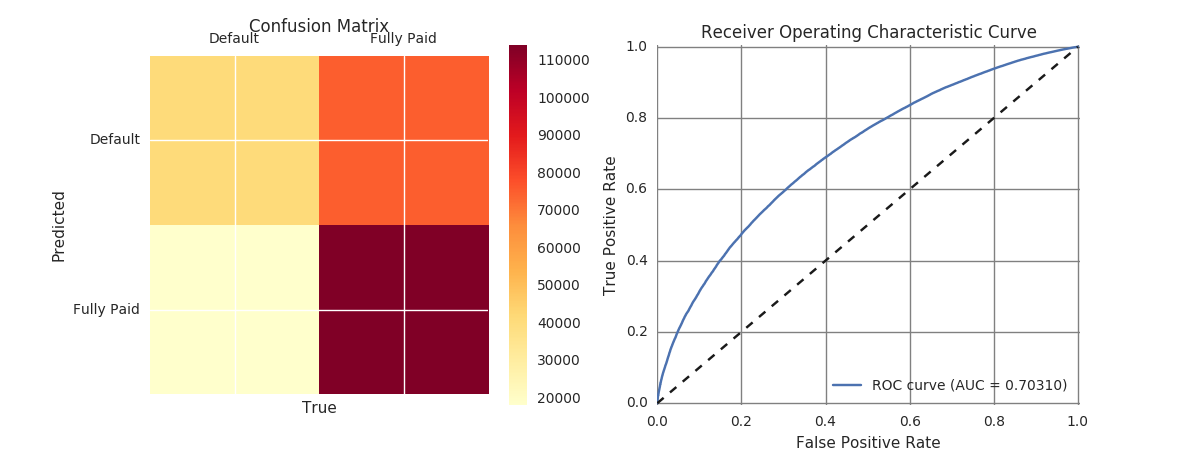

In [136]:
Confusion_ROC(predictions)

#### 4.2 Random Forest

In [138]:
# Create Random Forest Classifier model
rf_classifier = RandomForestClassifier(impurity="entropy", maxDepth=12, numTrees=10, featureSubsetStrategy="auto", seed=500)

# Train model with Training Data
rf_model = rf_classifier.fit(trainDF)

rf_predictions = rf_model.transform(testDF)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3978424509806620> in <module> () 
 3 
 4 # Train model with Training Data 
 ----> 5 rf_model = rf_classifier . fit ( trainDF ) 
 6 
 7 rf_predictions = rf_model . transform ( testDF ) 

 NameError : name 'trainDF' is not defined

In [139]:
# Random Forest Result
print("***The Result of Random Forest***")
getEvaluationMatrix(rf_predictions)

***The Result of Random Forest***
totalCount - 248654
correctCount - 190196
wrongCount - 58458
trueP - 2452
trueN - 187744
falseN - 56871
falseP - 1587
ratioWrong - 0.23509776637415847
ratioCorrect - 0.7649022336258415
Accuracy - 0.7649022336258415
Precision - 60.70809606338202
Recall - 4.133304114761559
F-1 Score - 7.73965468261734
Sensitivity - 4.133304114761559
Specificity - 99.16178544453894
AUCROC - 0.7051250065413951

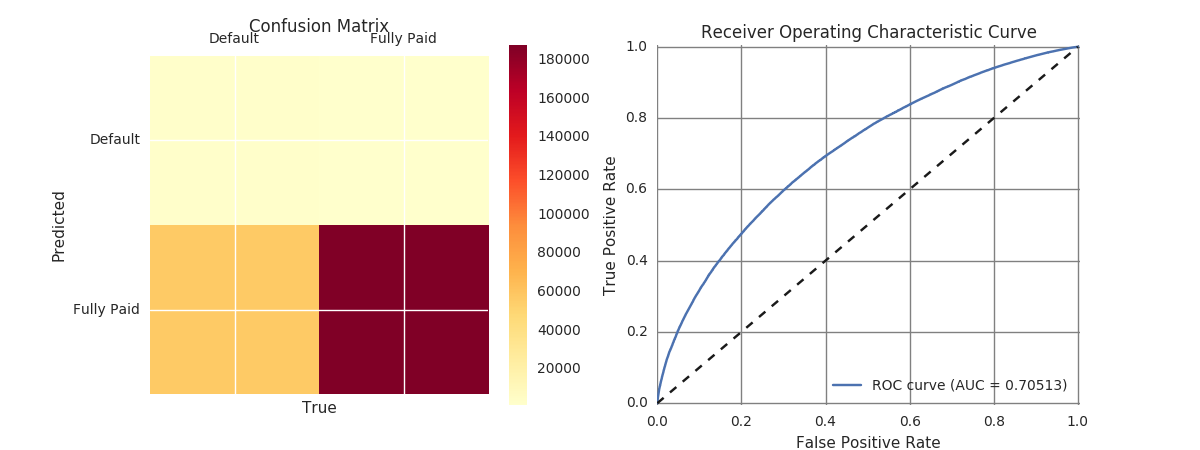

In [140]:
Confusion_ROC(rf_predictions)

The performance of random forest is slightly better than logistic regression in terms of AUCROC. In the following section, I'm going to fine tune random forest model. However, the predictions performance of logistic regression and random forest shown in confusion matrix are very differet. It will be further discussed in section 4.2.3.
#### 4.2.1 Model Tuning
Grid search and 5-fold cross validation are applied to find the hyperparameter of random forest model for the best performance.

In [142]:
paramGrid = ParamGridBuilder().addGrid(rf_classifier.maxBins, [25, 28, 31, 34]).addGrid(rf_classifier.maxDepth, [4, 6, 8, 12]).addGrid(rf_classifier.numTrees, [3, 5, 20]).build()

pipeline = Pipeline(stages=[ rf_classifier ])

evaluator = BinaryClassificationEvaluator( labelCol = "label" )

crossval = CrossValidator( estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit( trainDF )

cv_predictions = cvModel.transform(testDF)
cv_accuracy = evaluator.evaluate(cv_predictions)  

bestModel = cvModel.bestModel
print(cvModel.avgMetrics)
print(list(zip(cvModel.avgMetrics, paramGrid)))

print(bestModel.stages[0]._java_obj.getMaxBins())
print(bestModel.stages[0]._java_obj.getMaxDepth())
print(bestModel.stages[0]._java_obj.getImpurity())

print(cv_accuracy) 

[0.5831602489127953, 0.6312680242429776, 0.668365695357935, 0.6913062134155626, 0.58336283699665, 0.6380524022518153, 0.6673379930260621, 0.6895832831772115, 0.5904685059990082, 0.6307532497984595, 0.6652489878444399, 0.6902313151042438, 0.5830074829392105, 0.6303605857072574, 0.671935958013691, 0.6913240660398943, 0.623775241654008, 0.6820256525295108, 0.6915525545060803, 0.7001857743180746, 0.6176557661903187, 0.6733603740376791, 0.691370412980062, 0.7006410595766346, 0.6175649772566296, 0.6819484817377732, 0.6915656077283081, 0.6999941407090164, 0.6316570731909978, 0.6844752803336452, 0.6919988168854838, 0.7011351777605781, 0.6835621194397956, 0.6949919268530906, 0.7002544241580497, 0.7071377046639123, 0.6791677077132886, 0.6949149680228598, 0.7004064191162931, 0.7076603172445671, 0.6793851644687396, 0.6951901162441929, 0.7001261530091589, 0.7074466338365188, 0.6781413113827788, 0.6947021338643722, 0.7007222766249783, 0.7076701135461088]
[(0.5831602489127953, {Param(parent='RandomForestClassifier_f58147a04d44', name='numTrees', doc='Number of trees to train (>= 1).'): 3, Param(parent='RandomForestClassifier_f58147a04d44', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 25, Param(parent='RandomForestClassifier_f58147a04d44', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4}), (0.6312680242429776, {Param(parent='RandomForestClassifier_f58147a04d44', name='numTrees', doc='Number of trees to train (>= 1).'): 3, Param(parent='RandomForestClassifier_f58147a04d44', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 25, Param(parent='RandomForestClassifier_f58147a04d44', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6}), (0.668365695357935, {Param(parent='RandomForestClassifier_f58147a04d44', name='numTrees', doc='Number of trees to train (>= 1).'): 3, Param(parent='RandomForestClassifier_f58147a04d44', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 25, Param(parent='RandomForestClassifier_f58147a04d44', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8}), (0.6913062134155626, {Param(parent='RandomForestClassifier_f58147a04d44', name='numTrees', doc='Number of trees to train (>= 1).'): 3, Param(parent='RandomForestClassifier_f58147a04d44', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 25, Param(parent='RandomForestClassifier_f58147a04d44', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 12}), (0.58336283699665, {Param(parent='RandomForestClassifier_f58147a04d44', name='numTrees', doc='Number of trees to train (>= 1).'): 3, Param(parent='RandomForestClassifier_f58147a04d44', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 28, Param(parent='RandomForestClassifier_f58147a04d44', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4}), (0.6380524022518153, {Param(parent='RandomForestClassifier_f58147a04d44', name='numTrees', doc='Number of trees to train (>= 1).'): 3, Param(parent='RandomForestClassifier_f58147a04d44', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 28, Param(parent='RandomFores

In [143]:
print(bestModel.stages[0]._java_obj.getNumTrees())

20

In [144]:
print("***The Result of Random Forest with Fine-Tuned Hyperparameters***")
getEvaluationMatrix(cv_predictions)

***The Result of Random Forest with Fine-Tuned Hyperparameters***
totalCount - 248654
correctCount - 190112
wrongCount - 58542
trueP - 2086
trueN - 188026
falseN - 57237
falseP - 1305
ratioWrong - 0.23543558519066654
ratioCorrect - 0.7645644148093335
Accuracy - 0.7645644148093335
Precision - 61.51577705691537
Recall - 3.516342733846906
F-1 Score - 6.652422106706637
Sensitivity - 3.516342733846906
Specificity - 99.31073094210669
AUCROC - 0.7082914030000061

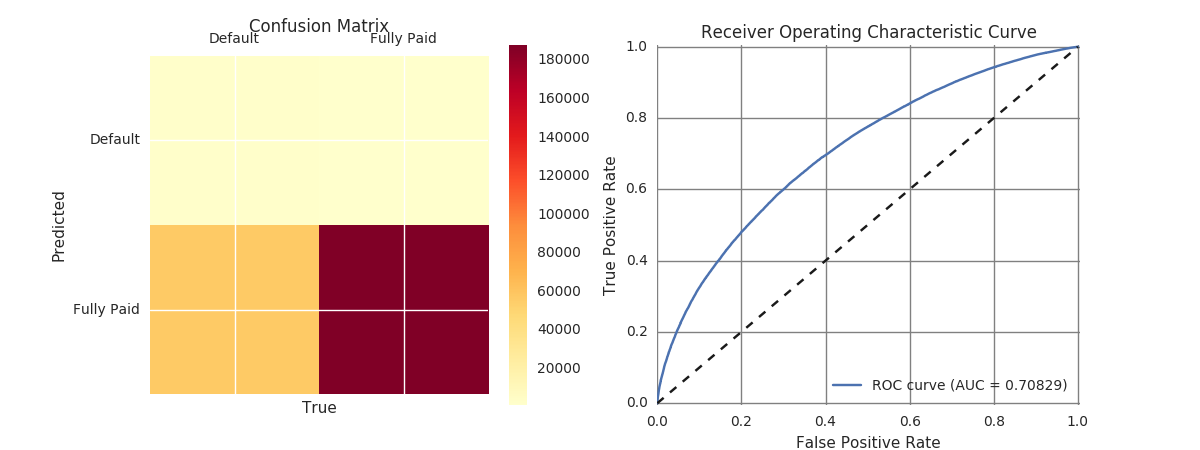

In [145]:
Confusion_ROC(cv_predictions)

After fine tuned, the model performance is slightly improved. I'm now reporting the feature importance from random forest model for more insights.
#### 4.2.2 Feature Importance
Under PySpark framework, the feature importance is presented in a sparse vector. However, this format is not quite readable, so the following function maps the vectorized features back with the feature names.

In [147]:
bestModel.stages[0].featureImportances

Out[ 134 ]: SparseVector(124, {0: 0.0331, 1: 0.2843, 2: 0.0199, 3: 0.0256, 4: 0.0773, 5: 0.0083, 6: 0.0031, 7: 0.01, 8: 0.0125, 9: 0.0355, 10: 0.0019, 11: 0.067, 12: 0.0056, 13: 0.1481, 14: 0.004, 15: 0.0017, 16: 0.0074, 17: 0.003, 18: 0.0045, 19: 0.0095, 20: 0.0046, 21: 0.0023, 22: 0.0016, 23: 0.006, 24: 0.0022, 25: 0.0094, 26: 0.0096, 27: 0.0017, 28: 0.0014, 29: 0.0146, 30: 0.0016, 31: 0.0016, 32: 0.0263, 33: 0.0123, 34: 0.0013, 35: 0.0137, 36: 0.0014, 37: 0.0017, 38: 0.0029, 39: 0.0014, 40: 0.0018, 41: 0.0008, 42: 0.0022, 43: 0.0002, 44: 0.0006, 45: 0.001, 46: 0.0002, 47: 0.0005, 48: 0.0003, 49: 0.0001, 50: 0.0001, 51: 0.0235, 52: 0.0165, 53: 0.0013, 57: 0.0019, 58: 0.0036, 59: 0.0298, 60: 0.0013, 61: 0.0019, 62: 0.001, 63: 0.0008, 64: 0.0006, 65: 0.0007, 66: 0.0014, 67: 0.0004, 68: 0.0003, 69: 0.0005, 70: 0.0004, 71: 0.0001, 72: 0.0001, 74: 0.0019, 75: 0.0012, 76: 0.0008, 77: 0.0009, 78: 0.0006, 79: 0.0008, 80: 0.0007, 81: 0.0007, 82: 0.0006, 83: 0.0006, 84: 0.0007, 85: 0.0005, 86: 0.0005, 87: 0.0006, 88: 0.0013, 89: 0.0007, 90: 0.0009, 91: 0.0005, 92: 0.0005, 93: 0.0005, 94: 0.0006, 95: 0.0006, 96: 0.0004, 97: 0.0004, 98: 0.0007, 99: 0.0006, 100: 0.0004, 101: 0.0005, 102: 0.0005, 103: 0.0005, 104: 0.0004, 105: 0.0003, 106: 0.0005, 107: 0.0003, 108: 0.0002, 109: 0.0003, 110: 0.0004, 111: 0.0004, 112: 0.0003, 113: 0.0002, 114: 0.0003, 115: 0.0002, 116: 0.0003, 117: 0.0004, 118: 0.0004, 119: 0.0002, 120: 0.0001, 121: 0.0001, 122: 0.0002})

In [148]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [149]:
ExtractFeatureImp(bestModel.stages[0].featureImportances, encoded2_vec, "features").head(10)

Out[ 139 ]: 
 idx name score
1 1 int_rate 0.284257
13 13 termIndex 0.148140
4 4 dti 0.077320
11 11 fico_score 0.066977
9 9 mort_acc 0.035523
0 0 loan_amnt 0.033131
59 59 OHE_verification_status_Not Verified 0.029829
32 32 OHE_sub_grade_A1 0.026346
3 3 annual_inc 0.025554
51 51 OHE_home_ownership_MORTGAGE 0.023475

#### 4.2.3 Discussion
As shown in the confusion matrix, the predictions of logistic regression and random forest are very different. Random forest performs pretty well in identifying “Fully Paid” (true negative), but not as good in predicting “Default”. However, the ratio of predicted positive and negative could be adjusted according to different thresholds that the model uses for making classification decision. Since random forest has better AUCROC, by properly choosing the threshold, the prediction made by random forest can be optimized against the interest of Lending Club.  
The profits and costs of true positive, true negative, false positive, and false negative are different, and they should all be considered to assess the business value of the model performance. The overall business value is:  

__business value__ = profit of paid loan x (__true negative__) - cost of default x (__false negative__) – potential revenue if the loan application is approved x (__false positive__)  

[note 1] For true positive, the model successfully predict default, and Lending Club could reject the loan application. Thus, Lending Club gain nothing and lose nothing.   
[note 2] profit of paid loan = potential revenue if the loan application is approved  

The threshold of the model should be chosen to maximize the business value. The profit and cost estimation for each scenario requires domain knowledge, so this project does not include threshold optimization.

## 5. Conclusion and Extension Suggestion
1. __The decision of Leading Club on interest rate is working well in general.__  
Lending Club offers higher interest rate to the clients with higher financial risks, and the interest rate turns out to be a good predictor on whether the clients are going to default. 

2. __The decision of the Lending Club on the loan grades works well on the clients with low credit risk.__  
The sub grade A1 is a good predictor. However, other grades may not have good predictive power. Therefore, Lending Club could review their grading formula for clients with worse credit/financial condition. 

3. __The clients show self-selection behavior. This finding is helpful to decrease the cost on information acquisition.__  
The term length and the loan amount are chosen by the clients, and these two features have good predictive power on whether they are going to default. In the case that collecting client’s data is costly, the self-select behavior is helpful for making quick decision.

4. __Based on the finding of the self-selection behavior, Lending Club could increase the long-term interest rate as the premium for higher default risk.__  
The clients who take long-term loan demonstrate higher default rate. Even though the long-term interest rate is already higher than short-term interest rate according to current Lending Club policy, it is worth to investigate whether the long-term interest rate is high enough to cover the higher risk and bring more profit to Lending Club. It should be aware that increasing interest rate could have adverse selection effect which further increase the risk from the clients. Therefore, adverse selection should be taken into account for adjusting the interest rate.

5. __The number of mortgage is a good predictor.__  
Mortgage is approved by other banks and financial institutes, and they already reviewed the financial and credit condition of the clients. Thus, the number of mortgages serves as a pre-evaluation.
6. __The threshold for the model should be properly tuned according to estimated profit from correct predictions and the estimated cost of wrong predictions.__  

7. __Extension: In the use case of building a predictive model for Lending Club to make loan decision, the same methodology can be applied on the same dataset without endogenous features (interest rate and loan grades).__